## More analysis plots (like in PerilsPlots.ipynb) used in McDonald and Weiss 2021 and Ostaszewski et al. 2024.

In [1]:
#from mpl_toolkits.basemap import Basemap
import datetime as dt
import matplotlib.pyplot as plt
#from WarningPoly import get_ww_fordate, plot_warning, plot_warning_filled

from netCDF4 import num2date
import numpy as np
import pyart;
import glob
import pytz
from functions_radar import get_radar_from_aws,_nearestDate
from scipy import interpolate
import matplotlib.cm as cm
import scipy.ndimage as nd
import pandas as pd
import pickle
import cmocean
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import cartopy
from metpy.plots import USCOUNTIES
from collections import OrderedDict
import geopandas as gpd
from metpy.plots import  StationPlot
import matplotlib.patheffects as path_effects
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind
# ################### Inputs that are changed #######################


station = 'KGWX'
target_date = '20220331'
analysis_time = dt.datetime(2022,3,31,0,12) #throw another comma in for minutes

# probe_locs = probe_info.probe_locs_2017

def convert_lon_lat(ref_lon,ref_lat,x,y):
    ''' This function takes a reference lon and lat (the location of the radar) and converts the x and y 
    coordinates in km from the radar (radar._get_x_y(...) into lons and lats for plotting on basemap)'''
    # Convert lat/lon to meters for conversion in a cartesian grid
    m1 = 111132.92  #lat calc term 1
    m2 = -559.82    #lat calc term 2
    m3 = 1.175      #lat calc term 3
    m4 = -0.0023    #lat calc term 4
    p1 = 111412.84  #lon calc term 1
    p2 = -93.5      #lon calc term 2
    p3 = 0.118      #lon calc term3
    
    x *= 1000
    y *=1000
    
    lat_convert = m1 + (m2*np.cos(np.deg2rad(2*ref_lat)))+(m3*np.cos(np.deg2rad(4*ref_lat)))+(m4*np.cos(np.deg2rad(6*ref_lat)))
    lon_convert = (p1 * np.cos(np.deg2rad(ref_lat))) + (p2 * np.cos(np.deg2rad(3*ref_lat)))+(p3*np.cos(np.deg2rad(5*ref_lat)))

    lon_pos = [(ref_lon+(x_pos/lon_convert)) for x_pos in x]
    lat_pos = [(ref_lat+(y_pos/lat_convert)) for y_pos in y]
    
    lon_pos = np.array(lon_pos)
    lat_pos = np.array(lat_pos)

    return lon_pos,lat_pos


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p14 = _nlv < LooseVersion("1.14")
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p15 = _nlv < LooseVersion("1.15")
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p16 = _nlv < LooseVersion("1.16")
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\compat\numpy\__

In [2]:
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3, fontsize=12, text_pad=5):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    text pad controls the spacing between the text (km, distance1, distance2) and the scale bar.
        squished numbers are bad!
    
    edited by Jessie. Found on GitHub - https://github.com/SciTools/cartopy/issues/490
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    # the edge is the black lines in between and extending on the edges of the white and gray parts
    # sbx is the center. length * 500 == half the length
    
    edge = 500
    bar_xs = [sbx - length * 500 - edge, sbx + length * 500 +edge]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth+4,solid_capstyle="butt")  # background
    
    #add colors - 4 colors
    x1, x2, x3, x4, x5 = sbx-length*500, sbx -length*250, sbx, sbx+length*250, sbx+length*500
    ax.plot([x1,x2-edge/2], [sby, sby], transform=tmc, color='w', linewidth=linewidth,solid_capstyle="butt")
    ax.plot([x2+edge/2,x3-edge/2] ,[sby, sby], transform=tmc, color='gray', linewidth=linewidth,solid_capstyle="butt")
    ax.plot([x3+edge/2,x4-edge/2] ,[sby, sby], transform=tmc, color='w', linewidth=linewidth,solid_capstyle="butt")
    ax.plot([x4+edge/2,x5] ,[sby, sby], transform=tmc, color='gray', linewidth=linewidth,solid_capstyle="butt")
    
    # add "km", center point, and end point
    y_lift = linewidth*text_pad
    ax.text(x3, sby+length*y_lift , str(round(2 * length / 4)), transform=tmc,
                    horizontalalignment='center', verticalalignment='bottom',
                    color='k', fontsize=fontsize)
    ax.text(x5-length*50, sby+length*y_lift , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color='k', fontsize=fontsize)
    ax.text(x1+length*60, sby+length*y_lift , 'km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color='k', fontsize=fontsize)

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

def plot_lat_lon(ax, lon_labels, lat_labels, top_label=False, left_label=False, bottom_label=True, right_label=True, linewidth=1,
                color='gray', text_color='gray',text_size=15, alpha=0.5, linestyle='--'):

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=linewidth, color=color, alpha=alpha, linestyle=linestyle)
    gl.xlabels_top = top_label
    gl.ylabels_left = left_label
    gl.xlabels_bottom = bottom_label
    gl.ylabels_right = right_label
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator(lon_labels)
    gl.ylocator = mticker.FixedLocator(lat_labels)
    gl.xformatter = LONGITUDE_FORMATTER

    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': text_size, 'color': text_color}
    gl.ylabel_style = {'size': text_size, 'color': text_color}
    
    
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib
import cmocean

def rgb(hexcol):
    return matplotlib.colors.to_rgba(hexcol)
def make_cmap(colors, n_bin=50):
    return LinearSegmentedColormap.from_list('newcmap', colors, N=n_bin)

def min_col(cmap, minval=0.0, maxval=1.0, n=15):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


### Reflec and Vel plots

In [3]:
shapefilewarn1 = gpd.read_file("E:\\PERiLS_Y1\\Tornado_Survey_PERiLS\\IOP2\\wwa_202203301200_202203311200.shp")
dfwarn1 = pd.DataFrame(shapefilewarn1)
shapefiletor1 = gpd.read_file("E:\\PERiLS_Y1\\Tornado_Survey_PERiLS\\IOP2\\nws_dat_damage_paths.shp")
dftor1 = pd.DataFrame(shapefiletor1) 
gdftor1 = gpd.GeoDataFrame(dftor1, geometry='geometry')
mask1 = (dfwarn1['GTYPE'] == 'P')
ds1 = dfwarn1.loc[mask1]
ds1['POLY_BEG'] = pd.to_datetime(dfwarn1['POLY_BEG'], format='%Y%m%d%H%M')
ds1['POLY_END'] = pd.to_datetime(dfwarn1['POLY_END'], format='%Y%m%d%H%M')
gdfwarn1 = gpd.GeoDataFrame(ds1, geometry='geometry')
masknew1 = (gdfwarn1.STATUS=='NEW')
shapefilefinal1 = gdfwarn1.loc[masknew1]
roadPalette = {'EF0': 'lawngreen',
               'EF1': 'orange',
               'EF2': 'red',
               'EF3': 'maroon',
               'UNKNOWN': 'grey'}

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationW

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

In [3]:
SNSfile = 'E:\\PERiLS_Y1\\Excel_SN\\After_CPA\\IOP3_Grad_Analysis.csv'
sns = pd.read_csv(SNSfile)

sns = sns.rename(columns={"TV_dist": "TV", "TE_dist": "TE"})
sns = sns[sns['TOA_coldpool_final'].notna()]

sns = sns.set_index(sns['ID'])

lats_all =        sns['lat'].values
lons_all =        sns['lon'].values
te_deficits_all = np.asarray(sns['TE'].values)
tv_deficits_all = np.asarray(sns['TV'].values)
dTVdn_all =       np.asarray(sns['dTVdn'].values)
toas_all =        pd.to_datetime(sns['TOA_coldpool_final'].values)

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

In [4]:
def get_1hz(date, probe, starttime, duration, seconds=False):
    print(probe)
    directory1= 'E:\\PERiLS_Y1\\Data\\PERiLS_data\\IOP_data\\IOP3_20220405\\level3\\'
    datafile = directory1+'0'+probe+'_level3.txt'
    data = pd.read_csv(datafile, header=0, index_col = 'Time', parse_dates=['Time'], date_parser=pd.to_datetime)
    if seconds == False:
       # handle when data from two days is needed
        s = (starttime-dt.timedelta(minutes=1))
        e = (starttime+dt.timedelta(minutes=duration))
       # if s.strftime('%d')!= e.strftime('%d'):
        #    datafile = "{}{}_{}.csv".format(directory, probe, e.strftime('%Y%m%d'))
         #   data2 = pd.read_csv(datafile, header=0, index_col = 'Time', parse_dates=['Time'], date_parser=pd.to_datetime)
          #  data = pd.concat([data.iloc[0:-1],data2])

        return data[starttime:starttime+dt.timedelta(minutes=duration)]
    if seconds == True:
       # handle when data from two days is needed
        s = (starttime-dt.timedelta(minutes=1))
        e = (starttime+dt.timedelta(seconds=duration))
        #if s.strftime('%d')!= e.strftime('%d'):
         #   datafile = "{}{}_{}.csv".format(directory, probe, e.strftime('%Y%m%d'))
         #   data2 = pd.read_csv(datafile, header=0, index_col = 'Time', parse_dates=['Time'], date_parser=pd.to_datetime)
          #  data = pd.concat([data.iloc[0:-1],data2])

        return data[starttime:starttime+dt.timedelta(seconds=duration)]

In [5]:
sns['TOA_coldpool_final']

ID
101A    2022/04/05 1500
102A    2022/04/05 1556
103A    2022/04/05 1506
104A    2022/04/05 1551
105A    2022/04/05 1538
106A    2022/04/05 1538
107A    2022/04/05 1553
108A    2022/04/05 1554
109A    2022/04/05 1500
110A    2022/04/05 1600
112A    2022/04/05 1523
213A    2022/04/05 1558
214A    2022/04/05 1602
215A    2022/04/05 1527
216A    2022/04/05 1503
216C    2022/04/05 1445
217A    2022/04/05 1417
218A    2022/04/05 1454
219A    2022/04/05 1516
220A    2022/04/05 1547
221A    2022/04/05 1543
222A    2022/04/05 1553
223A    2022/04/05 1554
Name: TOA_coldpool_final, dtype: object

In [6]:
appended_data = []
for i in [4,5,6]:
    data = get_1hz(sns['date'], sns.iloc[i].ID, dt.datetime(2022,4,5,15,29), 30)
    sampling_interval = '1Min'
    
    # variables
    avg_temp = np.round(data['T'].resample(sampling_interval, label='right').mean(),1)
    avg_P =    np.round(data['P'].resample(sampling_interval, label='right').mean(),1)
    avg_RH =   np.round(data['RH'].resample(sampling_interval, label='right').mean(),1)
    avg_ws =   np.round(data['WS'].resample(sampling_interval, label='right').mean(),1)
    times = avg_P.index
    
    # wind direction NOTE: can't do normal averaging for this, must break into u and v
    u,v = convert_wind(data['WS'], data['WD'])
    u_avg = u.resample(sampling_interval, label='right').mean()
    v_avg = v.resample(sampling_interval, label='right').mean()
    avg_wd = np.round(np.rad2deg(np.arctan2(u_avg, v_avg))+180,1) # rotate so 0 is N

    # put data into pandas dataframe
    d = {'T':avg_temp, 'RH':avg_RH, 'P':avg_P, 'WS':avg_ws, 'WD':avg_wd}
    met = pd.DataFrame(data=d,index=times).replace(-999.9,np.nan)
    met.sort_index(ascending = True, inplace = True)
    
    appended_data.append(met)
data_df = pd.concat(appended_data)

105A


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

106A


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

107A


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

In [7]:
data_df[0:32]

T    RH      P   WS     WD
Time                                              
2022-04-05 15:30:00  19.5  99.3  996.2  3.7  282.6
2022-04-05 15:31:00  19.5  99.0  996.6  4.4  278.4
2022-04-05 15:32:00  19.5  98.9  997.1  5.2  276.4
2022-04-05 15:33:00  19.6  98.6  997.1  4.6  277.6
2022-04-05 15:34:00  19.7  98.1  997.4  4.3  275.4
2022-04-05 15:35:00  19.7  97.6  997.6  4.4  247.8
2022-04-05 15:36:00  19.8  96.7  997.7  5.5  242.2
2022-04-05 15:37:00  19.9  96.7  997.7  6.1  234.1
2022-04-05 15:38:00  19.9  96.5  997.7  5.7  244.8
2022-04-05 15:39:00  19.7  96.4  997.8  4.4  236.6
2022-04-05 15:40:00  19.6  97.0  997.8  5.0  240.8
2022-04-05 15:41:00  19.5  96.7  997.9  5.6  235.5
2022-04-05 15:42:00  19.3  97.1  998.1  4.2  247.5
2022-04-05 15:43:00  19.2  97.0  998.3  4.9  237.6
2022-04-05 15:44:00  19.2  97.1  998.4  3.3  239.8
2022-04-05 15:45:00  19.1  97.5  998.3  2.4  222.4
2022-04-05 15:46:00  19.0  97.6  998.2  1.9  237.8
2022-04-05 15:47:00  19.0  97.8  998.1  2.6  249.9
2022-04-05 15:48:00  18.9  97.6  998.2  3.8  263.2
2022-04-05 15:49:00  18.9  97.6  998.3  2.7  244.5
2022-04-05 15:50:00  18.8  97.8  998.3  3.0  206.1
2022-04-05 15:51:00  18.8  97.4  998.3  4.1  237.7
2022-04-05 15:52:00  18.8  97.2  998.1  3.4  213.7
2022-04-05 15:53:00  18.8  97.2  998.1  3.4  237.9
2022-04-05 15:54:00  18.8  97.0  998.1  3.7  220.5
2022-04-05 15:55:00  18.8  97.0  998.0  2.1  234.7
2022-04-05 15:56:00  18.8  97.0  997.8  3.5  208.4
2022-04-05 15:57:00  18.7  97.3  997.6  1.8  235.4
2022-04-05 15:58:00  18.7  97.8  997.5  1.1  261.7
2022-04-05 15:59:00  18.7  97.6  997.3  1.7  265.3
2022-04-05 16:00:00  18.7  97.2  997.2  2.0  270.0
2022-04-05 15:30:00  18.5  98.9  985.8  3.4  271.4

In [16]:
len(data_df)

120

In [19]:
data_df['WS'][0:12].values

array([8.1, 7.6, 6.8, 6.5, 7.9, 5.5, 6.5, 6.6, 6.9, 6.1, 4.9, 7.1])

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

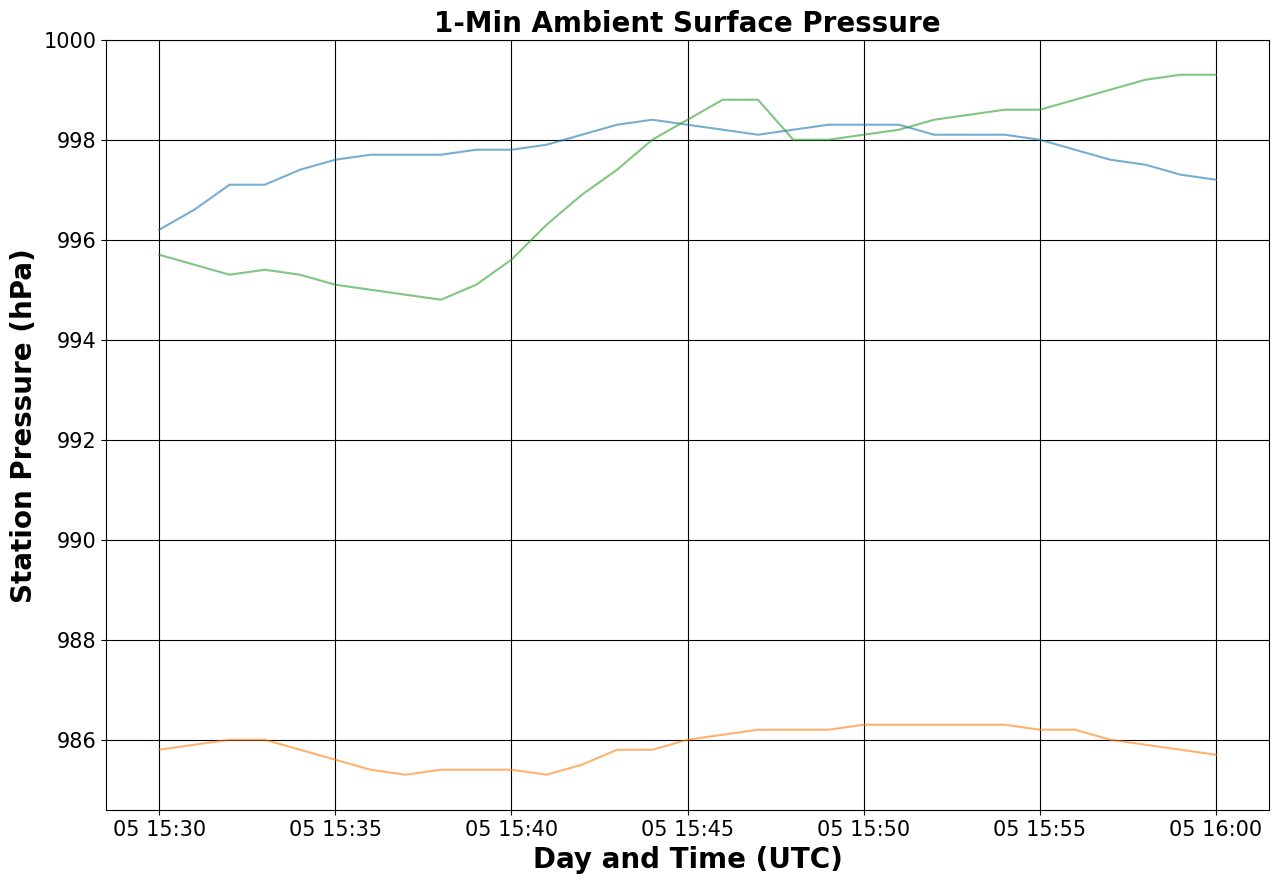

In [8]:
fig, ax1 = plt.subplots(figsize=(15, 10))

for i in range(0, len(data_df), 31):
    test = data_df['P'][i:i+31].values
    ax1.plot(data_df.index[0:31],test,alpha=0.6)
    plt.xlabel('Day and Time (UTC)')
    #plt.xticks(rotation=45)
    
    ax1.set_xlabel('Day and Time (UTC)', fontsize=20,fontweight='bold')
    ax1.set_ylabel('Station Pressure (hPa)', color='k', fontsize=20,fontweight='bold')
    plt.title('1-Min Ambient Surface Pressure', fontsize=20,fontweight='bold')
ax1.grid(color='k',alpha=1.0)
#ax2.grid(color='grey',alpha=1.0)
ax1.tick_params(axis='both', which='major', labelsize=15, labelcolor='k')
#ax2.tick_params(axis='y', which='major', labelsize=15, labelcolor='grey')
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('E:\\IOP3_sfcpressure.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

<>:20: DeprecationWarning: invalid escape sequence \m
<>:20: DeprecationWarning: invalid escape sequence \m
<>:20: DeprecationWarning: invalid escape sequence \m
C:\Users\joshu\AppData\Local\Temp\ipykernel_21744\981450072.py:20: DeprecationWarning: invalid escape sequence \m
  ax2.set_ylabel('Wind Speed $\mathregular{(m\ s^{-1})}$', color='grey', fontsize=20,fontweight='bold')
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: Deprecation

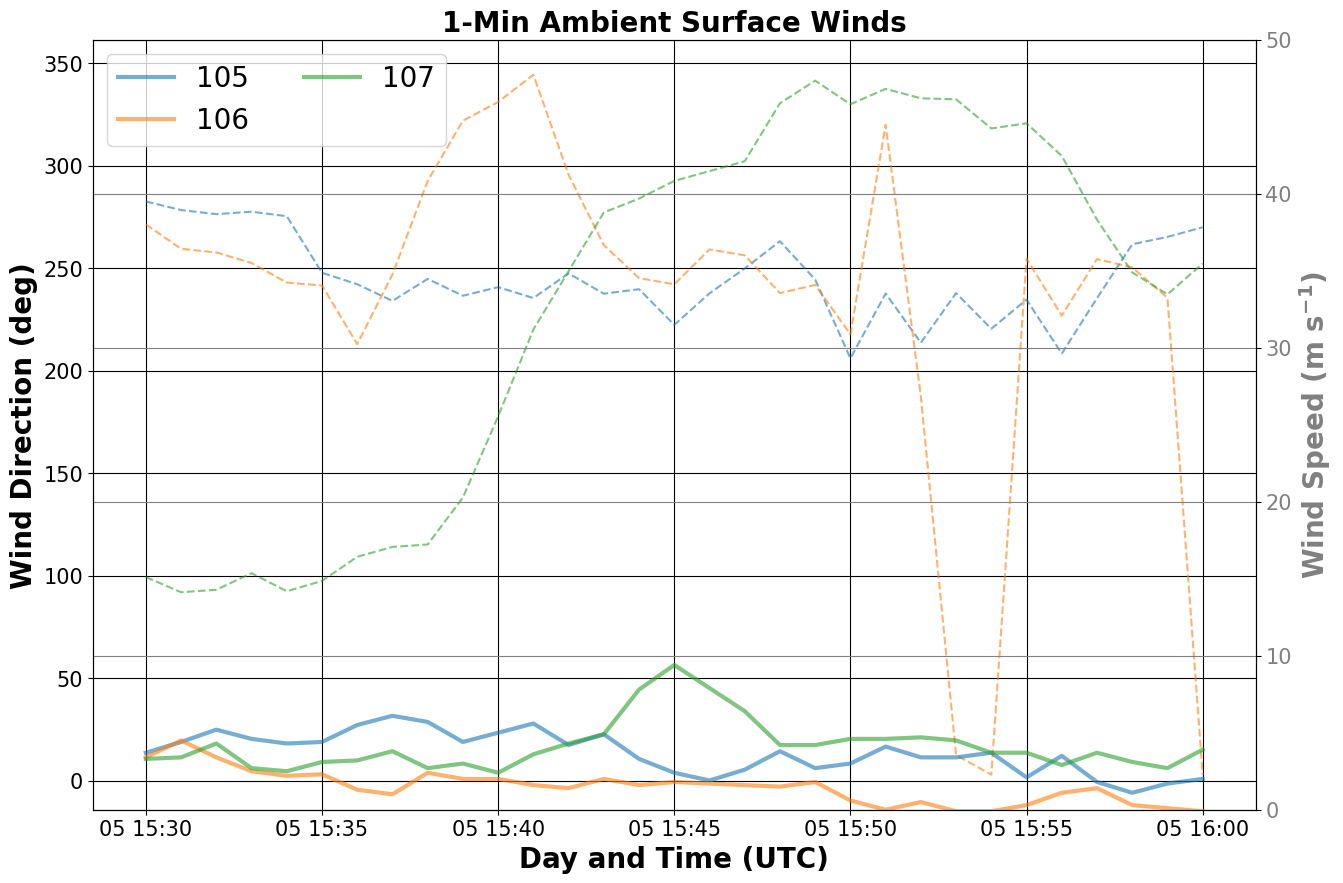

In [10]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx() 
ax2.set_ylim([0,50])

for i in range(0, len(data_df), 31):
    test = data_df['WD'][i:i+31].values
    ax1.plot(data_df.index[0:31],test,linestyle='--',alpha=0.6)
    test1 = data_df['WS'][i:i+31].values
    ax2.plot(data_df.index[0:31],test1, alpha=0.6, linewidth=3)
    plt.legend(['105','106','107'], ncol=2, loc='upper left', fontsize=20)
    #plt.legend(['103','104','110','111','213','214','215','220','221'], ncol=2, loc='upper left', fontsize=20)
    #plt.legend(['102','108','110','213','214','220','221','223'], loc='upper right')
    #plt.legend(['102','110','213','220','221','223'], ncol=2,loc='upper left', fontsize=20)
    #plt.legend(['103','104','108','109','111','112','215','218','220','224'], ncol=2,loc='upper left', fontsize=20)
    plt.xlabel('Day and Time (UTC)')
    plt.xticks(rotation=45)
    
    ax1.set_xlabel('Day and Time (UTC)', fontsize=20,fontweight='bold')
    ax1.set_ylabel('Wind Direction (deg)', color='k', fontsize=20,fontweight='bold')
    ax2.set_ylabel('Wind Speed $\mathregular{(m\ s^{-1})}$', color='grey', fontsize=20,fontweight='bold')
    plt.title('1-Min Ambient Surface Winds', fontsize=20,fontweight='bold')
ax1.grid(color='k',alpha=1.0)
ax2.grid(color='grey',alpha=1.0)
ax1.tick_params(axis='both', which='major', labelsize=15, labelcolor='k')
ax2.tick_params(axis='y', which='major', labelsize=15, labelcolor='grey')
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('E:\\IOP3_sfcwinds.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

In [14]:
testingu = np.hstack(rapidu_min2)
testingv = np.hstack(rapidv_min2)

In [15]:
utest,vtest = convert_wind(data_df['WS'].values,data_df['WD'].values)
urapidtest,vrapidtest = testingu,testingv
srutest,srvtest = ((utest/1.94384)-(urapidtest)),((vtest/1.94384)-(vrapidtest))
SRwdtest = np.rad2deg(np.arctan2(srutest,srvtest))+180
SRwstest = np.sqrt((srutest**2)+(srvtest**2))

<>:18: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
C:\Users\joshu\AppData\Local\Temp\ipykernel_13268\1162892078.py:18: DeprecationWarning: invalid escape sequence \m
  ax2.set_ylabel('Wind Speed $\mathregular{(m\ s^{-1})}$', color='grey', fontsize=20,fontweight='bold')
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: Deprecatio

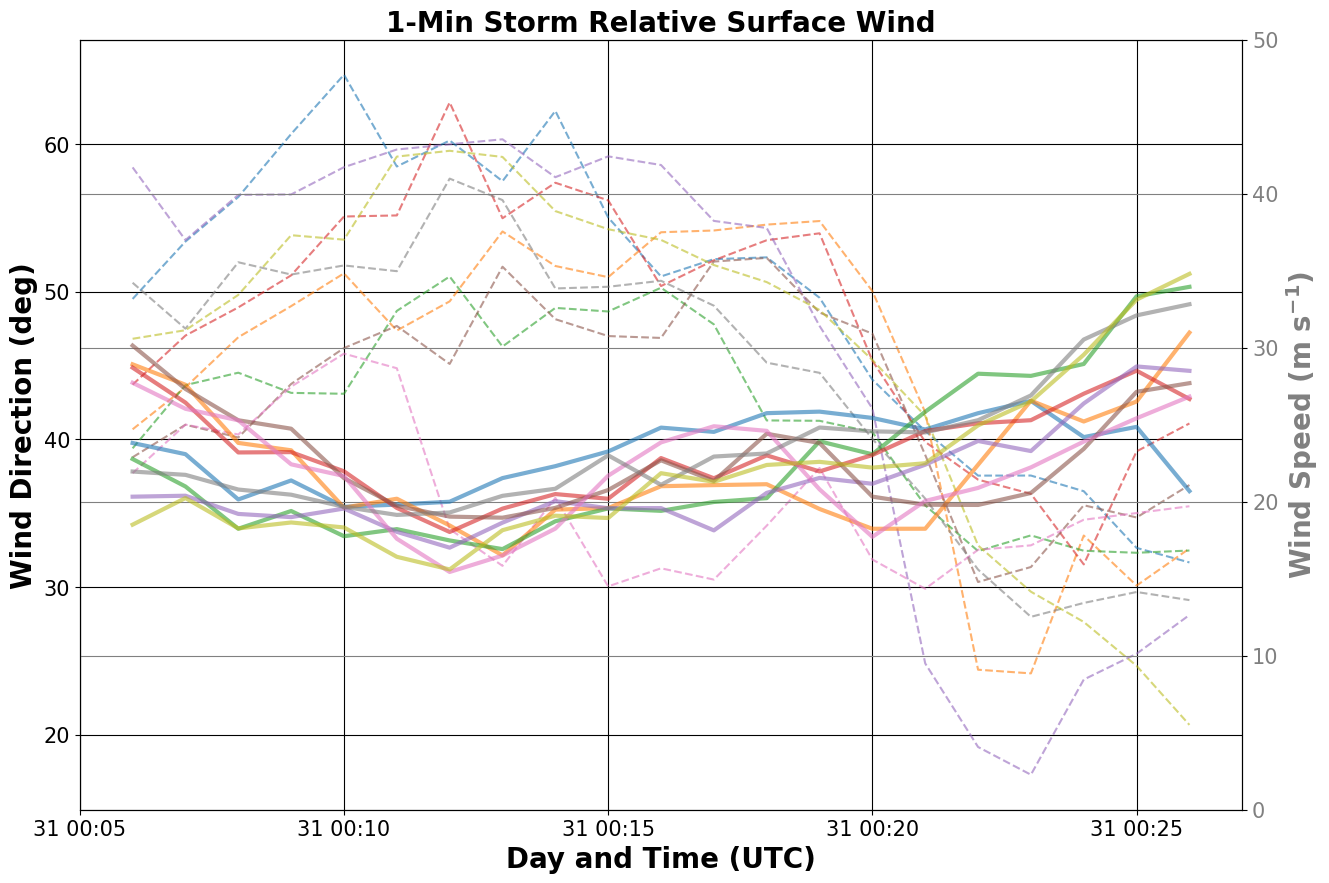

In [16]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx() 
ax2.set_ylim([0,50])

for i in range(0, len(data_df), 21):
    test = SRwdtest[i:i+21]
    ax1.plot(data_df.index[0:21],test,linestyle='--',alpha=0.6)
    test1 = SRwstest[i:i+21]
    ax2.plot(data_df.index[0:21],test1, alpha=0.6, linewidth=3)
    #plt.legend(['103','104','110','111','213','214','215','220','221'], ncol=2, loc='lower left')
    #plt.legend(['102','108','110','213','214','220','221','223'], loc='upper right')
#     plt.legend(['102','110','213','220','221','223'], ncol=2,loc='lower left')
    #plt.legend(['103','104','108','109','111','112','215','218','220','224'], ncol=2,loc='upper left')
    plt.xlabel('Day and Time (UTC)')
    plt.xticks(rotation=45)
    ax1.set_xlabel('Day and Time (UTC)', fontsize=20,fontweight='bold')
    ax1.set_ylabel('Wind Direction (deg)', color='k', fontsize=20,fontweight='bold')
    ax2.set_ylabel('Wind Speed $\mathregular{(m\ s^{-1})}$', color='grey', fontsize=20,fontweight='bold')
    plt.title('1-Min Storm Relative Surface Wind', fontsize=20,fontweight='bold')
ax1.grid(color='k',alpha=1.0)
ax2.grid(color='grey',alpha=1.0)
ax1.tick_params(axis='both', which='major', labelsize=15, labelcolor='k')
ax2.tick_params(axis='y', which='major', labelsize=15, labelcolor='grey')
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('E:\\SRwindIOP2.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

In [123]:
data_df['WS'][50:60]

Time
2022-04-13 20:13:00     4.2
2022-04-13 20:14:00     4.6
2022-04-13 20:15:00     4.5
2022-04-13 20:16:00     5.0
2022-04-13 20:17:00     8.4
2022-04-13 20:18:00    14.2
2022-04-13 20:19:00    12.7
2022-04-13 20:20:00    11.8
2022-04-13 20:21:00    11.9
2022-04-13 20:22:00    13.2
Name: WS, dtype: float64

In [55]:
data_df['WS']

Time
2022-03-31 00:06:00    5.9
2022-03-31 00:07:00    6.8
2022-03-31 00:08:00    7.9
2022-03-31 00:09:00    8.2
2022-03-31 00:10:00    9.0
                      ... 
2022-03-31 00:22:00    5.4
2022-03-31 00:23:00    5.5
2022-03-31 00:24:00    4.6
2022-03-31 00:25:00    5.1
2022-03-31 00:26:00    7.2
Name: WS, Length: 189, dtype: float64

In [149]:
data_df['WS']

70

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

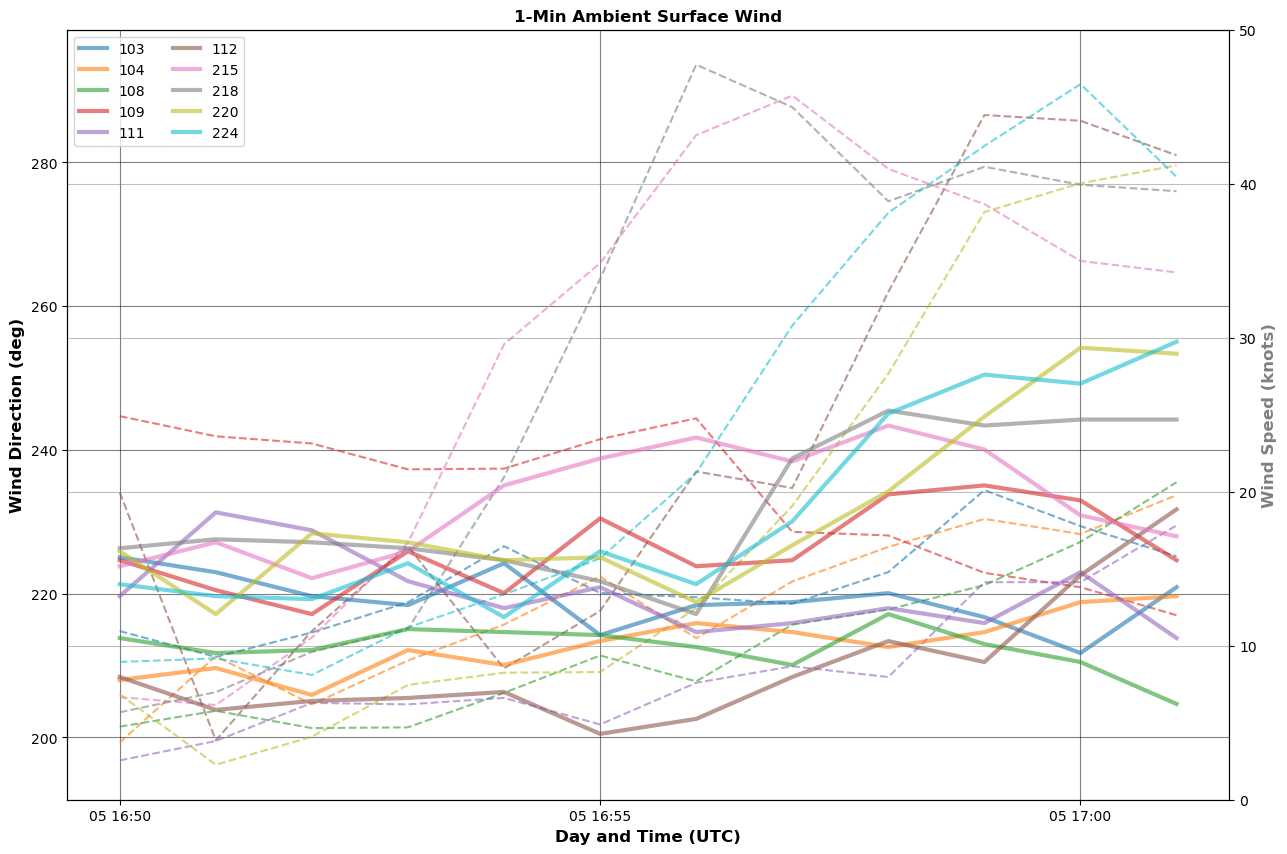

In [299]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx() 
ax2.set_ylim([0,50])

for i in range(0, len(data_df), 12):
    test = data_df['WD'][i:i+12]
    ax1.plot(data_df.index[0:12],test,linestyle='--',alpha=0.6)
    test1 = data_df['WS'][i:i+12]
    ax2.plot(data_df.index[0:12],test1*1.94384, alpha=0.6, linewidth=3)
    #plt.legend(['103','104','110','111','213','214','215','220','221'], ncol=2, loc='upper left')
    #plt.legend(['102','108','110','213','214','220','221','223'], loc='upper right')
    #plt.legend(['102','110','213','220','221','223'], ncol=2,loc='upper right')
    plt.legend(['103','104','108','109','111','112','215','218','220','224'], ncol=2,loc='upper left')
    plt.xticks(rotation=45)
    ax1.set_xlabel('Day and Time (UTC)', fontsize=12,fontweight='bold')
    ax1.set_ylabel('Wind Direction (deg)', color='k', fontsize=12,fontweight='bold')
    ax2.set_ylabel('Wind Speed (knots)', color='grey', fontsize=12,fontweight='bold')
    plt.title('1-Min Ambient Surface Wind', fontsize=12,fontweight='bold')
ax1.grid(color='k',alpha=0.5)
ax2.grid(color='grey',alpha=0.5)
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('E:\\AmbientwindIOP5.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

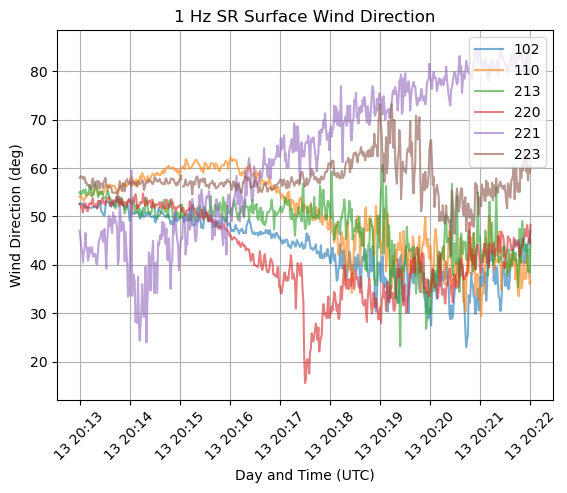

In [563]:
for i in range(0, len(data_df), 541):
    test = SRwdtest[i:i+541]
    plt.plot(data_df.index[0:541],test, alpha=0.6)
    #plt.legend(['103','104','110','111','213','214','215','220','221'], loc='upper right')
    #plt.legend(['102','108','110','213','214','220','221','223'], loc='upper right')
    plt.legend(['102','110','213','220','221','223'], loc='upper right')
    plt.xlabel('Day and Time (UTC)')
    plt.xticks(rotation=45)
    plt.ylabel('Wind Direction (deg)')
    plt.title('1 Hz SR Surface Wind Direction')
plt.grid()
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('{0}Hz_SRwinddir4.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

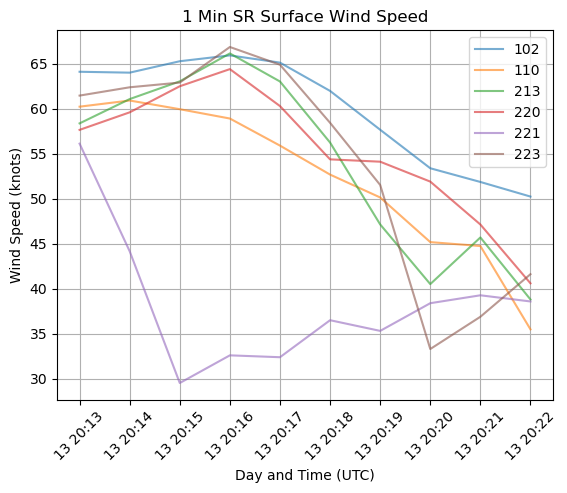

In [555]:
for i in range(0, len(data_df), 10):
    test = SRwstest[i:i+10]
    plt.plot(data_df.index[0:10],test, alpha=0.6)
    #plt.legend(['103','104','110','111','213','214','215','220','221'], loc='upper center')
    #plt.legend(['102','108','110','213','214','220','221','223'], loc='lower left')
    plt.legend(['102','110','213','220','221','223'], loc='upper right')
    plt.xlabel('Day and Time (UTC)')
    plt.xticks(rotation=45)
    plt.ylabel('Wind Speed (knots)')
    plt.title('1 Min SR Surface Wind Speed')
plt.grid()
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('{0}Min_SRwindspeed4.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

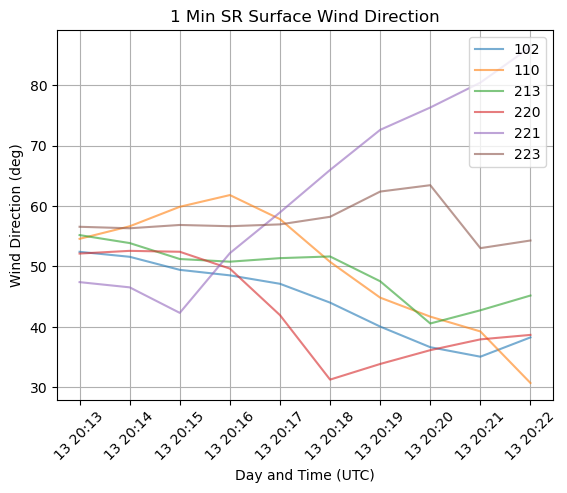

In [556]:
for i in range(0, len(data_df), 10):
    test = SRwdtest[i:i+10]
    plt.plot(data_df.index[0:10],test, alpha=0.6)
    #IOP1 plt.legend(['103','104','110','111','213','214','215','220','221'], loc='lower left')
    #plt.legend(['102','108','110','213','214','220','221','223'], loc='upper right')
    plt.legend(['102','110','213','220','221','223'], loc='upper right')
    plt.xlabel('Day and Time (UTC)')
    plt.xticks(rotation=45)
    plt.ylabel('Wind Direction (deg)')
    plt.title('1 Min SR Surface Wind Direction')
plt.grid()
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('{0}Min_SRwinddir4.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

In [49]:
test['WD']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

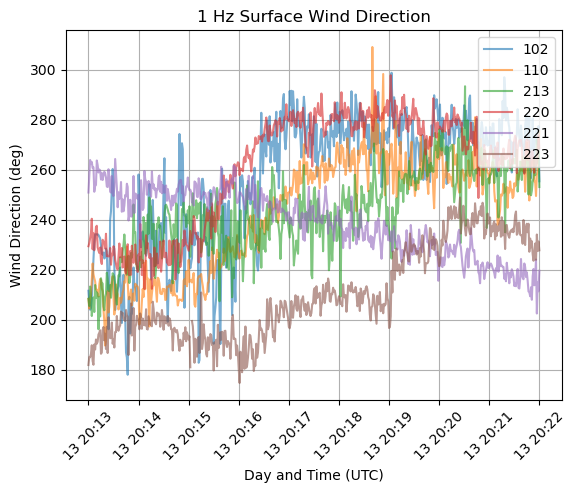

In [565]:
for i in range(0, len(data_df), 541):
    test = data_df.iloc[i:i+541]
    plt.plot(test['WD'], alpha=0.6)
    #plt.legend(['103','104','110','111','213','214','215','220','221'], loc='lower left')
    #plt.legend(['102','108','110','213','214','220','221','223'], loc='lower left')
    plt.legend(['102','110','213','220','221','223'], loc='upper right')
    plt.xlabel('Day and Time (UTC)')
    plt.xticks(rotation=45)
    plt.ylabel('Wind Direction (deg)')
    plt.title('1 Hz Surface Wind Direction')
plt.grid()
file_dir = 'C:\\Users\\joshu\\Desktop\\'
plt.savefig('{0}Hz_winddir4.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300)
plt.show()

In [12]:
rapid_probes3 = sns.iloc[[1,6,8,10,11,18,19,21],:]
rapid_probes2 = sns.iloc[[2,3,9,10,12,13,14,19,20],:]
rapid_probes4 = sns.iloc[[1,8,11,17,18,20],:]
#rapid_probes5 = sns.iloc[[2,3,7,8,10,11,14,17,19,23],:]

In [33]:
rapid_probes4

C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data

IOP       date    ID        lat        lon array_type        mode  \
ID                                                                        
102A    4  4/13/2022  102A  36.176796 -89.753913       Fine  Mesovortex   
110A    4  4/13/2022  110A  36.193963 -89.759267       Fine  Mesovortex   
213A    4  4/13/2022  213A  36.131550 -89.753087       Fine  Mesovortex   
220A    4  4/13/2022  220A  36.159819 -89.753844       Fine  Mesovortex   
221A    4  4/13/2022  221A  36.232225 -89.822553     Coarse  Mesovortex   
223A    4  4/13/2022  223A  36.145337 -89.753675       Fine  Mesovortex   

      MC_rel_toa  MV_H_dist type  ... ref_contour SM_mods ref_mods BS_mods  \
ID                                ...                                        
102A         NaN        1.0    R  ...          46     NaN      NaN     NaN   
110A         NaN        3.0    R  ...          46     NaN      NaN     NaN   
213A         NaN        5.0    R  ...          40     NaN      NaN     NaN   
220A         NaN        1.0    R  ...          40     NaN      NaN     NaN   
221A         NaN       12.0    R  ...          44     NaN      NaN     NaN   
223A         NaN        3.0    R  ...          40     NaN      NaN     NaN   

         TE    TV  dTVdn  Tdd_BS   TE_BS   TV_BS  
ID                                                
102A -10.32 -6.11  -5.50    4.42  332.18  297.80  
110A -10.32 -6.39  -4.08    5.02  332.88  298.41  
213A -12.01 -6.57  -2.40    4.52  334.67  298.65  
220A  -9.93 -5.66  -2.38    3.73  333.86  297.91  
221A  -9.70 -4.30  -2.12    1.65  333.32  296.43  
223A  -9.92 -5.53  -2.51    4.01  333.83  298.06  

[6 rows x 35 columns]

In [13]:
rapidu_HZ2 = (np.concatenate((np.linspace(rapid_probes2['U6'], rapid_probes2['U12'], 361)[:-1],np.linspace(rapid_probes2['U12'], rapid_probes2['U20'], 481)[:-1],
                          np.linspace(rapid_probes2['U20'], rapid_probes2['U26'], 361))).T)
rapidv_HZ2 = (np.concatenate((np.linspace(rapid_probes2['V6'], rapid_probes2['V12'], 361)[:-1],np.linspace(rapid_probes2['V12'], rapid_probes2['V20'], 481)[:-1],
                          np.linspace(rapid_probes2['V20'], rapid_probes2['V26'], 361)))).T
rapidu_min2 = (np.concatenate((np.linspace(rapid_probes2['U6'], rapid_probes2['U12'], 7)[:-1],np.linspace(rapid_probes2['U12'], rapid_probes2['U20'], 9)[:-1],
                          np.linspace(rapid_probes2['U20'], rapid_probes2['U26'], 7))).T)
rapidv_min2 = (np.concatenate((np.linspace(rapid_probes2['V6'], rapid_probes2['V12'], 7)[:-1],np.linspace(rapid_probes2['V12'], rapid_probes2['V20'], 9)[:-1],
                          np.linspace(rapid_probes2['V20'], rapid_probes2['V26'], 7)))).T

In [291]:
rapidu_min5

array([[15.1       , 18.48      , 21.86      , 25.24      , 28.62      ,
        32.        , 33.        , 34.        , 35.        , 36.        ,
        37.        ],
       [15.1       , 17.14      , 19.18      , 21.22      , 23.26      ,
        25.3       , 26.93333333, 28.56666667, 30.2       , 31.83333333,
        33.46666667],
       [15.1       , 16.74      , 18.38      , 20.02      , 21.66      ,
        23.3       , 25.26666667, 27.23333333, 29.2       , 31.16666667,
        33.13333333],
       [21.1       , 20.94      , 20.78      , 20.62      , 20.46      ,
        20.3       , 19.83333333, 19.36666667, 18.9       , 18.43333333,
        17.96666667],
       [15.1       , 17.32      , 19.54      , 21.76      , 23.98      ,
        26.2       , 28.16666667, 30.13333333, 32.1       , 34.06666667,
        36.03333333],
       [15.1       , 16.14      , 17.18      , 18.22      , 19.26      ,
        20.3       , 23.73333333, 27.16666667, 30.6       , 34.03333333,
        37.466

In [10]:
rapidu_min5 = (np.concatenate((np.linspace(rapid_probes5['U50'], rapid_probes5['U55'], 6)[:-1],
                          np.linspace(rapid_probes5['U55'], rapid_probes5['U01'], 7))).T)
rapidv_min5 = (np.concatenate((np.linspace(rapid_probes5['V50'], rapid_probes5['V55'], 6)[:-1],
                          np.linspace(rapid_probes5['V55'], rapid_probes5['V01'], 7))).T)


In [415]:
rapidu_HZ3 = (np.concatenate((np.linspace(rapid_probes3['U41'], rapid_probes3['U47'], 361)[:-1],np.linspace(rapid_probes3['U47'], rapid_probes3['U53'], 361)[:-1],
                          np.linspace(rapid_probes3['U53'], rapid_probes3['U59'], 361)[:-1],np.linspace(rapid_probes3['U59'], rapid_probes3['U6'], 421)[:-1],
                          np.linspace(rapid_probes3['U6'], rapid_probes3['U13'], 421))).T)
rapidv_HZ3 = (np.concatenate((np.linspace(rapid_probes3['V41'], rapid_probes3['V47'], 361)[:-1],np.linspace(rapid_probes3['V47'], rapid_probes3['V53'], 361)[:-1],
                          np.linspace(rapid_probes3['V53'], rapid_probes3['V59'], 361)[:-1],np.linspace(rapid_probes3['V59'], rapid_probes3['V6'], 421)[:-1],
                          np.linspace(rapid_probes3['V6'], rapid_probes3['V13'], 421)))).T
rapidu_min3 = (np.concatenate((np.linspace(rapid_probes3['U41'], rapid_probes3['U47'], 7)[:-1],np.linspace(rapid_probes3['U47'], rapid_probes3['U53'], 7)[:-1],
                          np.linspace(rapid_probes3['U53'], rapid_probes3['U59'], 7)[:-1],np.linspace(rapid_probes3['U59'], rapid_probes3['U6'], 8)[:-1],
                          np.linspace(rapid_probes3['U6'], rapid_probes3['U13'], 8))).T)
rapidv_min3 = (np.concatenate((np.linspace(rapid_probes3['V41'], rapid_probes3['V47'], 7)[:-1],np.linspace(rapid_probes3['V47'], rapid_probes3['V53'], 7)[:-1],
                          np.linspace(rapid_probes3['V53'], rapid_probes3['V59'], 7)[:-1],np.linspace(rapid_probes3['V59'], rapid_probes3['V6'], 8)[:-1],
                          np.linspace(rapid_probes3['V6'], rapid_probes3['V13'], 8)))).T

In [34]:
#start at 13
rapidu_HZ4 = (np.concatenate((np.linspace(rapid_probes4['U11'], rapid_probes4['U16'], 181)[:-1],np.linspace(rapid_probes4['U16'], rapid_probes4['U22'], 361)))).T
rapidv_HZ4 = (np.concatenate((np.linspace(rapid_probes4['V11'], rapid_probes4['V16'], 181)[:-1],np.linspace(rapid_probes4['V16'], rapid_probes4['V22'], 361)))).T
rapidu_min4 = (np.concatenate((np.linspace(rapid_probes4['U11'], rapid_probes4['U16'], 4)[:-1],np.linspace(rapid_probes4['U16'], rapid_probes4['U22'], 7)))).T
rapidv_min4 = (np.concatenate((np.linspace(rapid_probes4['V11'], rapid_probes4['V16'], 4)[:-1],np.linspace(rapid_probes4['V16'], rapid_probes4['V22'], 7)))).T

In [56]:
u

Time
2022-03-31 00:05:00     0.903367
2022-03-31 00:05:01    -0.558561
2022-03-31 00:05:02     2.245762
2022-03-31 00:05:03    -3.315091
2022-03-31 00:05:04    -2.718436
                         ...    
2022-03-31 00:24:56    11.030223
2022-03-31 00:24:57    12.381271
2022-03-31 00:24:58    12.982927
2022-03-31 00:24:59    13.288437
2022-03-31 00:25:00    12.481284
Length: 1201, dtype: float64

In [95]:
dewp_c = calc_dewpoint(data_df['T'].values,data_df['RH'].values)
thetae = calc_thetae(data_df['T'].values,dewp_c, data_df['P'].values)
thetav = calc_thetav(data_df['T'].values,dewp_c, data_df['P'].values)
u,v = convert_wind(data_df['WS'].values,data_df['WD'].values)
SRU,SRV = u-(rapid_probes4['U16'].values*1.94384),v-(rapid_probes4['V16'].values*1.94384)
SRwd = np.rad2deg(np.arctan2(SRU, SRV))+180
SRws = np.sqrt((SRU**2)+(SRV**2))

ValueError: operands could not be broadcast together with shapes (70,) (7,) 

In [50]:
data_df['WS']

Time
2022-03-31 00:06:00    5.9
2022-03-31 00:07:00    6.8
2022-03-31 00:08:00    7.9
2022-03-31 00:09:00    8.2
2022-03-31 00:10:00    9.0
                      ... 
2022-03-31 00:22:00    5.4
2022-03-31 00:23:00    5.5
2022-03-31 00:24:00    4.6
2022-03-31 00:25:00    5.1
2022-03-31 00:26:00    7.2
Name: WS, Length: 189, dtype: float64

In [429]:
def get_vals(field):
# Set plotting ranges for radar fields
    if field == 'reflectivity':
        vmin = 0
        vmax = 70
        sweep = 0
        cbar_label = 'Reflectivity (dBZ)'
        cmap = 'pyart_NWSRef'
    elif field == 'velocity':
        vmin = -24 #-30
        vmax = 24 #30
        sweep = 1
        cbar_label = r'Radial Velocity (m s$^{-1}$)'
        cmap = 'pyart_Carbone42'#ctables.registry.get_with_steps('Carbone42', 16,16)
    return vmin,vmax,sweep,cbar_label,cmap

def plot_radar_sticknet_RefandVel(radar, date, warning_poly = None, event=None):
    """ Function takes in a radar object and data from StickNets to plot the surface observations
    on top of the radar sweep. 
    Required inputs:
        radar: pyart radar object
        data: dictionary of sticknet T,P,RH,etc.
        obstime: Valid time of StickNet data
    Optional inputs:
        field: radar field name given in a string (i.e., reflectivity, velocity)
    """
    #Set up Plot
    crs = ccrs.PlateCarree()
    # Get data to plot state and province boundaries
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lakes',
            scale='10m',
            facecolor='none')
    west_lon=-88.6
    south_lat=33.65
    east_lon=-88.3
    north_lat=33.95
      # add the rapid probes                
#     rapid_locs = {
#      '0222': [-87.26764,34.472091],
#      '0221': [-87.296503,34.523322],
#      '0219': [-87.120229,34.394485],
#      '0218': [-87.21975,34.448162],
#      '0224': [-87.16902,34.420291],
#      '0220': [-87.500392,34.639214]}

    #lon_add, lat_add
    LL = (west_lon),(north_lat)
    UR = (east_lon ),(south_lat)
    LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
    UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())
    

    
    # Initialize plot and basemap
    fig = plt.figure(figsize = [22,10])
    
    
    
    
    # REFLECTIVITY
    ax =  fig.add_subplot(121, projection=crs)
    #ax.set_aspect('auto')
        
    ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots

    # plot the warning poly
#     poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
#     plot_warnings(poly, ax, linewidth = 3,alpha=0.8, color='#bc1010',label = None)#    

    # add the StickNets
    pe= [path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()]
    
    lat,lon = rapid_probes2['lat'].values,rapid_probes2['lon'].values
    ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=5)
    stationplot = StationPlot(ax, lon, lat,clip_on=True, transform=crs, fontsize=9, weight='bold')
    stationplot.plot_text((-3, -1), rapid_probes2['ID'], fontsize=12, weight='bold', path_effects=pe)
    
    ax.plot(sns.loc[sns['ID']=='104A'].lon,sns.loc[sns['ID']=='104A'].lat, marker = 's', color = 'grey', linewidth=0.0, 
        markersize = 5, markeredgewidth=5)
    
    ax.barbs(lon, lat, SRU, SRV, length=10,sizes={'emptybarb':.18}, lw=2.5,zorder=20)

#     if probe in ['0102A', '0106A', '0214A', '0111A', '0217A','0112A'] :
#         ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
#             markersize = 12, markeredgewidth=7)
#         ax.plot(lon,lat, marker = 's', color = '#74a9b8', linewidth=0.0, 
#             markersize = 12, markeredgewidth=3)

#     if probe == '0107A':
#         ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
#             markersize = 12, markeredgewidth=7)
#         ax.plot(lon,lat, marker = 's', color = '#b85151', linewidth=0.0, 
#             markersize = 12, markeredgewidth=3)
                    
            
            
 
    vmin,vmax,sweep,cbar_label,cmap = get_vals('reflectivity')
    cmap = pyart.graph.cm_colorblind.HomeyerRainbow
    
        # Grab indeces and times from radar object
    
    field = 'reflectivity'
    sweep = 2
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    # getting contours
    #x,y = display._get_x_y(sweep = 0, edges = False, filter_transitions = True)
    ref_lat = display.loc[0]
    ref_lon = display.loc[1]
    #lon_pos,lat_pos = convert_lon_lat(ref_lon,ref_lat,x,y)
    data_reflec = radar.get_field(0,'reflectivity')
    data_vel = radar.get_field(1,'velocity')

    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    #central = pytz.timezone('US/Central')
    #local_time = central.fromutc(time_at_start_of_radar)
    #fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    fancy_date_string_utc = time_at_start_of_radar.strftime('%H%M UTC %d %b %Y')
    
#     image = ax.contourf(lon_pos,lat_pos,data_reflec,levels = np.arange(0,71,5),cmap = 'pyart_NWSRef'\
#                       , alpha=0.7, lw=0, antialiased=True)
    
    image = display.plot_ppi_map('reflectivity', sweep, cmap=cmap, ax=ax, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs, lat_lines=[0], lon_lines=[0], alpha=0.8)
    
    # plot tornado track
#     tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
#     ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#             color = 'k', linewidth=9)
#     ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))
    
    # adds larger title and gives stylistic control over colorbar
  
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax, alpha=0.8, shrink=.8)
    cbar.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar.ax.tick_params(labelsize = 14)
     #title
    title = '{0} {1}, {2}'.format(station,'WSR-88D',fancy_date_string_utc)
    plt.suptitle(title, fontsize = 24, y = 0.93, weight='bold')
    
    # add legend and mapscale
#     handles, labels =ax.get_legend_handles_labels()
#     by_label = OrderedDict(zip(labels, handles))
#     ax.legend(by_label.values(), by_label.keys(),fontsize=14, loc=3, framealpha=1)
    
       
    # Mark the radar
    ax.plot(lon_0, lat_0, marker='o', color='r')

    gdftor1.plot(ax=ax,color='k',linewidth=5,alpha=0.3)
    
    # corc;e
#     circ = plt.Circle((-86.94, 34.27), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax.add_patch(circ)
    
#     circ = plt.Circle((-87.08, 34.76), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax.add_patch(circ)
    
#     circ = plt.Circle((-87.19, 34.86), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4, label='Mesovortex')
#     ax.add_patch(circ)

    
    #VELOCITY
    
    ax1 = fig.add_subplot(122, projection=crs)
    #ax1.set_aspect('auto')
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    
    ax1.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax1.add_feature(states_provinces, edgecolor='k', alpha=0.3, linewidth=2)
    ax1.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots

    # plot the warning poly
#     poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
#     plot_warnings(poly, ax1, linewidth = 3,alpha=0.8, color='#bc1010',label = 'Tor Warning')#    

    # add the StickNets
    ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=5)
    ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=3)
    stationplot1 = StationPlot(ax1, lon, lat,clip_on=True, transform=crs, fontsize=9, weight='bold')
    stationplot1.plot_text((-3, -1), rapid_probes2['ID'], fontsize=12, weight='bold', path_effects=pe)
            
    ax1.plot(sns.loc[sns['ID']=='104A'].lon,sns.loc[sns['ID']=='104A'].lat, marker = 's', color = 'grey', linewidth=0.0, 
        markersize = 5, markeredgewidth=5)
    
    ax1.barbs(lon, lat, SRU, SRV, length=10,sizes={'emptybarb':.18}, lw=2.5,zorder=20)
            
            
    vmin,vmax,sweep,cbar_label,cmap = get_vals('velocity')
    vmin = -30
    vmax = 30
    cmap = cmocean.cm.balance
#     x,y = display._get_x_y(sweep = 1, edges = False, filter_transitions = True)
#     lon_pos,lat_pos = convert_lon_lat(ref_lon,ref_lat,x,y)
        
    image2 = display.plot_ppi_map('velocity', sweep, cmap=cmap, ax=ax1, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs,lat_lines=[0], lon_lines=[0])

        # plot tornado track
#     tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
#     ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#             color = 'k', linewidth=9)
#     ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))
 
    # adds larger title and gives stylistic control over colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax1,shrink=.8)
    cbar2.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar2.ax.tick_params(labelsize = 14)
    
    # Mark the radar
    ax1.plot(lon_0, lat_0, marker='o', color='r')
    
    
    gdftor1.plot(ax=ax1,color='k',linewidth=5,alpha=0.3)
    
    
    # corc;e
#     circ = plt.Circle((-86.94, 34.27), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)
    
#     circ = plt.Circle((-87.08, 34.76), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)
    
#     circ = plt.Circle((-87.19, 34.86), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)

    #scale_bar(ax1, length=20, location=(0.87, 0.03), linewidth=8, fontsize=14, text_pad=10)
    
    plt.subplots_adjust(wspace=0.03)#, top = .89) #.03,.84
    
    
#     ax.text(.02, 0.94, 'a)',  fontsize=28, color='k', alpha=0.6,weight='bold',  transform=ax.transAxes,
#             bbox=dict(facecolor='w', edgecolor='w', pad=1))
#     ax1.text(.02, 0.94, 'b)', fontsize=28, color='k', alpha=0.6,weight='bold', transform=ax1.transAxes,
#              bbox=dict(facecolor='w', edgecolor='w', pad=1))
    
    # print statement
#     print('saved image from {0}'.format(fancy_date_string_utc))

#     # save fig
    file_dir = 'C:\\Users\\joshu\\Desktop\\'
#     '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/Pub_Figures/'
    plt.savefig('{0}TOA_plus2_SRwinds.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300);
    plt.show()   

0 0


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\

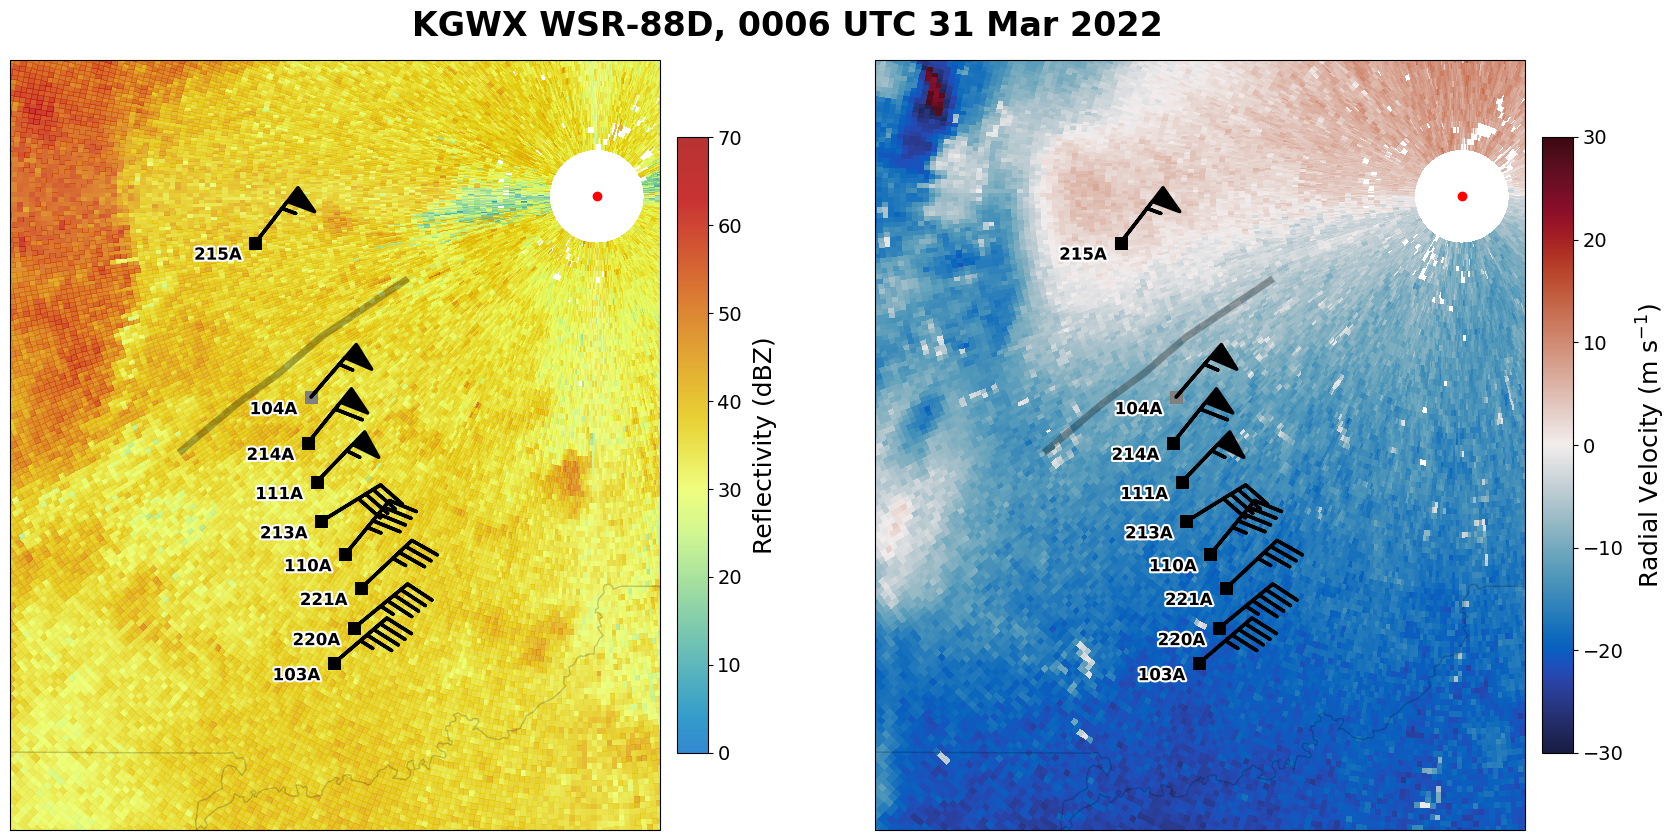

In [430]:
#station = 'KOHX'
station = 'KGWX'
from netCDF4 import num2date # KEEP THIS, num2date gets clobbered by reading in tor tracks
import matplotlib.lines as mlines

analysis_time11 = dt.datetime(2022,3,31,0,6)
radar_namelist11, radar_list11 = get_radar_from_aws(station, analysis_time11, analysis_time11)
radar11 = radar_list11[0]

# analysis_time1 = dt.datetime(2022,3,31,0,12)
# radar_namelist1, radar_list1 = get_radar_from_aws(station, analysis_time1, analysis_time1)
# radar1 = radar_list1[0]

# analysis_time2 = dt.datetime(2022,3,31,0,20)
# radar_namelist2, radar_list2 = get_radar_from_aws(station, analysis_time2, analysis_time2)
# radar2 = radar_list2[0]

# analysis_time3 = dt.datetime(2022,3,31,0,26)
# radar_namelist3, radar_list3 = get_radar_from_aws(station, analysis_time3, analysis_time3)
# radar3 = radar_list3[0]

plot_radar_sticknet_RefandVel(radar11, '20220331')

In [316]:
def get_vals(field):
# Set plotting ranges for radar fields
    if field == 'reflectivity':
        vmin = 0
        vmax = 70
        sweep = 0
        cbar_label = 'Reflectivity (dBZ)'
        cmap = 'pyart_NWSRef'
    elif field == 'velocity':
        vmin = -24 #-30
        vmax = 24 #30
        sweep = 1
        cbar_label = r'Radial Velocity (m s$^{-1}$)'
        cmap = 'pyart_Carbone42'#ctables.registry.get_with_steps('Carbone42', 16,16)
    return vmin,vmax,sweep,cbar_label,cmap

def plot_radar_sticknet_RefandVel(radar, date, warning_poly = None, event=None):
    """ Function takes in a radar object and data from StickNets to plot the surface observations
    on top of the radar sweep. 
    Required inputs:
        radar: pyart radar object
        data: dictionary of sticknet T,P,RH,etc.
        obstime: Valid time of StickNet data
    Optional inputs:
        field: radar field name given in a string (i.e., reflectivity, velocity)
    """
    #Set up Plot
    crs = ccrs.PlateCarree()
    # Get data to plot state and province boundaries
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lakes',
            scale='10m',
            facecolor='none')
    west_lon=-86.5
    south_lat=32.05
    east_lon=-86.2
    north_lat=32.45
      # add the rapid probes                
#     rapid_locs = {
#      '0222': [-87.26764,34.472091],
#      '0221': [-87.296503,34.523322],
#      '0219': [-87.120229,34.394485],
#      '0218': [-87.21975,34.448162],
#      '0224': [-87.16902,34.420291],
#      '0220': [-87.500392,34.639214]}

    #lon_add, lat_add
    LL = (west_lon),(north_lat)
    UR = (east_lon ),(south_lat)
    LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
    UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())
    

    
    # Initialize plot and basemap
    fig = plt.figure(figsize = [17,10])
    
    
    
    
    # REFLECTIVITY
    ax =  fig.add_subplot(121, projection=crs)
    #ax.set_aspect('auto')
        
    ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots

    # plot the warning poly
#     poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
#     plot_warnings(poly, ax, linewidth = 3,alpha=0.8, color='#bc1010',label = None)#    

    # add the StickNets
    pe= [path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()]
    
    lat,lon = rapid_probes3['lat'].values,rapid_probes3['lon'].values
    ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=5)
    stationplot = StationPlot(ax, lon, lat,clip_on=True, transform=crs, fontsize=9, weight='bold')
    stationplot.plot_text((-3, -1), rapid_probes3['ID'], fontsize=12, weight='bold', path_effects=pe)
    ax.barbs(lon, lat, SRU, SRV, length=10,sizes={'emptybarb':.18}, lw=2.5,zorder=20)
    ax.plot(sns.loc[sns['ID']=='104A'].lon,sns.loc[sns['ID']=='104A'].lat, marker = 's', color = 'grey', linewidth=0.0, 
        markersize = 5, markeredgewidth=5)
    
    

#     if probe in ['0102A', '0106A', '0214A', '0111A', '0217A','0112A'] :
#         ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
#             markersize = 12, markeredgewidth=7)
#         ax.plot(lon,lat, marker = 's', color = '#74a9b8', linewidth=0.0, 
#             markersize = 12, markeredgewidth=3)

#     if probe == '0107A':
#         ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
#             markersize = 12, markeredgewidth=7)
#         ax.plot(lon,lat, marker = 's', color = '#b85151', linewidth=0.0, 
#             markersize = 12, markeredgewidth=3)
                    
            
            
 
    vmin,vmax,sweep,cbar_label,cmap = get_vals('reflectivity')
    cmap = pyart.graph.cm_colorblind.HomeyerRainbow
    
        # Grab indeces and times from radar object
    
    field = 'reflectivity'
    sweep = 2
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    # getting contours
    #x,y = display._get_x_y(sweep = 0, edges = False, filter_transitions = True)
    ref_lat = display.loc[0]
    ref_lon = display.loc[1]
    #lon_pos,lat_pos = convert_lon_lat(ref_lon,ref_lat,x,y)
    data_reflec = radar.get_field(0,'reflectivity')
    data_vel = radar.get_field(1,'velocity')

    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    #central = pytz.timezone('US/Central')
    #local_time = central.fromutc(time_at_start_of_radar)
    #fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    fancy_date_string_utc = time_at_start_of_radar.strftime('%H%M UTC %d %b %Y')
    
#     image = ax.contourf(lon_pos,lat_pos,data_reflec,levels = np.arange(0,71,5),cmap = 'pyart_NWSRef'\
#                       , alpha=0.7, lw=0, antialiased=True)
    
    image = display.plot_ppi_map('reflectivity', sweep, cmap=cmap, ax=ax, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs, lat_lines=[0], lon_lines=[0], alpha=0.8)
    
    # plot tornado track
#     tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
#     ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#             color = 'k', linewidth=9)
#     ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))
    
    # adds larger title and gives stylistic control over colorbar
  
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax, alpha=0.8, shrink=.8)
    cbar.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar.ax.tick_params(labelsize = 14)
     #title
    title = '{0} {1}, {2}'.format(station,'WSR-88D',fancy_date_string_utc)
    plt.suptitle(title, fontsize = 24, y = 0.93, weight='bold')
    
    # add legend and mapscale
#     handles, labels =ax.get_legend_handles_labels()
#     by_label = OrderedDict(zip(labels, handles))
#     ax.legend(by_label.values(), by_label.keys(),fontsize=14, loc=3, framealpha=1)
    
       
    # Mark the radar
    ax.plot(lon_0, lat_0, marker='o', color='r')

    gdftor1.plot(ax=ax,color='k',linewidth=5,alpha=0.3)
    
    # corc;e
#     circ = plt.Circle((-86.94, 34.27), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax.add_patch(circ)
    
#     circ = plt.Circle((-87.08, 34.76), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax.add_patch(circ)
    
#     circ = plt.Circle((-87.19, 34.86), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4, label='Mesovortex')
#     ax.add_patch(circ)

    
    #VELOCITY
    
    ax1 = fig.add_subplot(122, projection=crs)
    #ax1.set_aspect('auto')
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    
    ax1.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax1.add_feature(states_provinces, edgecolor='k', alpha=0.3, linewidth=2)
    ax1.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots

    # plot the warning poly
#     poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
#     plot_warnings(poly, ax1, linewidth = 3,alpha=0.8, color='#bc1010',label = 'Tor Warning')#    

    # add the StickNets
    ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=5)
    ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=3)
    stationplot1 = StationPlot(ax1, lon, lat,clip_on=True, transform=crs, fontsize=9, weight='bold')
    stationplot1.plot_text((-3, -1), rapid_probes3['ID'], fontsize=12, weight='bold', path_effects=pe)
            
    ax1.plot(sns.loc[sns['ID']=='104A'].lon,sns.loc[sns['ID']=='104A'].lat, marker = 's', color = 'grey', linewidth=0.0, 
        markersize = 5, markeredgewidth=5)
    
    ax1.barbs(lon, lat, SRU, SRV, length=10,sizes={'emptybarb':.18}, lw=2.5,zorder=20)
            
            
    vmin,vmax,sweep,cbar_label,cmap = get_vals('velocity')
    vmin = -30
    vmax = 30
    cmap = cmocean.cm.balance
#     x,y = display._get_x_y(sweep = 1, edges = False, filter_transitions = True)
#     lon_pos,lat_pos = convert_lon_lat(ref_lon,ref_lat,x,y)
        
    image2 = display.plot_ppi_map('velocity', sweep, cmap=cmap, ax=ax1, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs,lat_lines=[0], lon_lines=[0])

        # plot tornado track
#     tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
#     ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#             color = 'k', linewidth=9)
#     ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))
 
    # adds larger title and gives stylistic control over colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax1,shrink=.8)
    cbar2.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar2.ax.tick_params(labelsize = 14)
    
    # Mark the radar
    ax1.plot(lon_0, lat_0, marker='o', color='r')
    
    
    gdftor1.plot(ax=ax1,color='k',linewidth=5,alpha=0.3)
    
    
    # corc;e
#     circ = plt.Circle((-86.94, 34.27), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)
    
#     circ = plt.Circle((-87.08, 34.76), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)
    
#     circ = plt.Circle((-87.19, 34.86), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)

    #scale_bar(ax1, length=20, location=(0.87, 0.03), linewidth=8, fontsize=14, text_pad=10)
    
    plt.subplots_adjust(wspace=0.03)#, top = .89) #.03,.84
    
    
#     ax.text(.02, 0.94, 'a)',  fontsize=28, color='k', alpha=0.6,weight='bold',  transform=ax.transAxes,
#             bbox=dict(facecolor='w', edgecolor='w', pad=1))
#     ax1.text(.02, 0.94, 'b)', fontsize=28, color='k', alpha=0.6,weight='bold', transform=ax1.transAxes,
#              bbox=dict(facecolor='w', edgecolor='w', pad=1))
    
    # print statement
#     print('saved image from {0}'.format(fancy_date_string_utc))

#     # save fig
    file_dir = 'C:\\Users\\joshu\\Desktop\\'
#     '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/Pub_Figures/'
    plt.savefig('{0}TOASRwinds3_2.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300);
    plt.show()  

144 144


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\

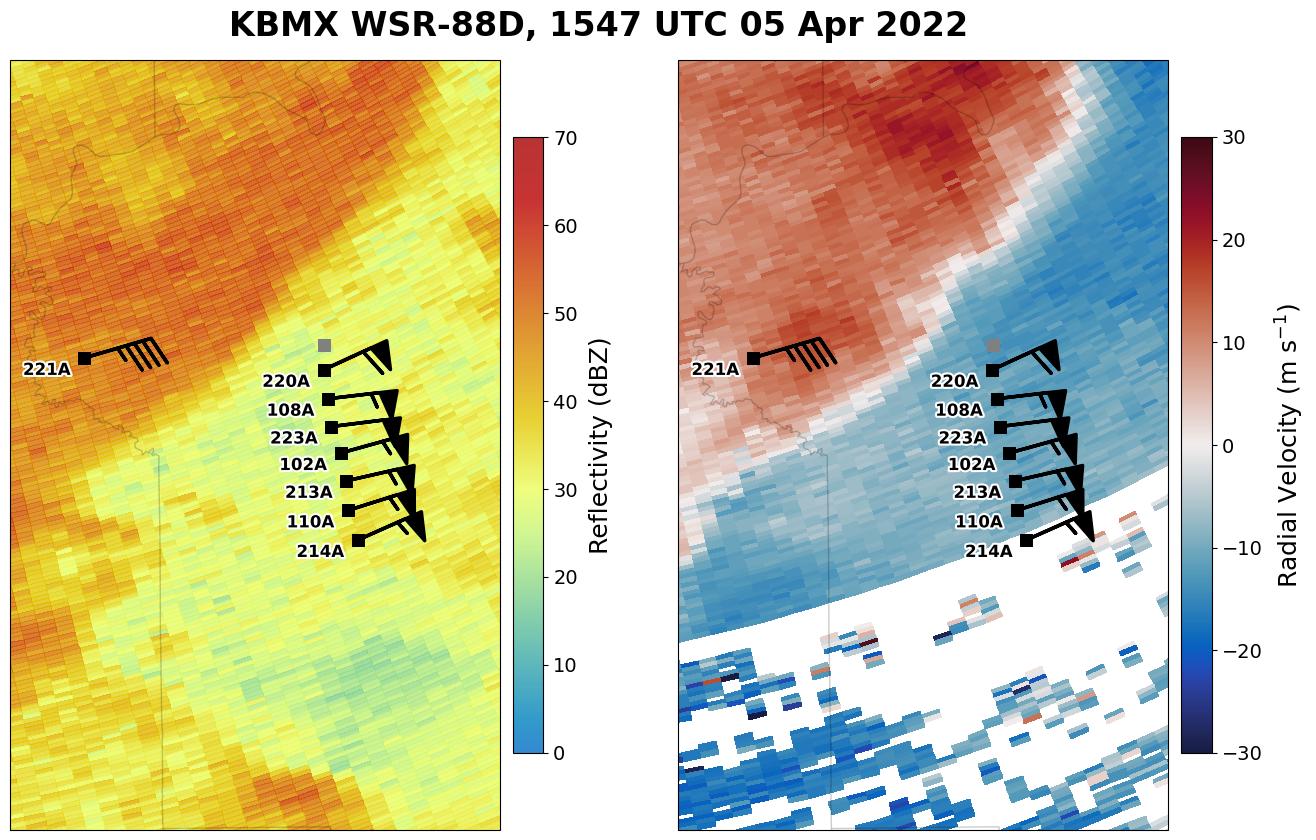

In [317]:
#station = 'KOHX'
station = 'KBMX'
from netCDF4 import num2date # KEEP THIS, num2date gets clobbered by reading in tor tracks
import matplotlib.lines as mlines

# analysis_time11 = dt.datetime(2022,4,5,15,40)
# radar_namelist11, radar_list11 = get_radar_from_aws(station, analysis_time11, analysis_time11)
# radar11 = radar_list11[0]

analysis_time1 = dt.datetime(2022,4,5,15,46)
radar_namelist1, radar_list1 = get_radar_from_aws(station, analysis_time1, analysis_time1)
radar1 = radar_list1[0]

# analysis_time2 = dt.datetime(2022,4,5,15,53)
# radar_namelist2, radar_list2 = get_radar_from_aws(station, analysis_time2, analysis_time2)
# radar2 = radar_list2[0]

# analysis_time3 = dt.datetime(2022,4,5,16,0)
# radar_namelist3, radar_list3 = get_radar_from_aws(station, analysis_time3, analysis_time3)
# radar3 = radar_list3[0]

# analysis_time4 = dt.datetime(2022,4,5,16,7)
# radar_namelist4, radar_list4 = get_radar_from_aws(station, analysis_time4, analysis_time4)
# radar4 = radar_list4[0]

# analysis_time5 = dt.datetime(2022,4,5,16,13)
# radar_namelist5, radar_list5 = get_radar_from_aws(station, analysis_time5, analysis_time5)
# radar5 = radar_list5[0]

plot_radar_sticknet_RefandVel(radar1, '20220405') #also change file name

In [579]:
def get_vals(field):
# Set plotting ranges for radar fields
    if field == 'reflectivity':
        vmin = 0
        vmax = 70
        sweep = 0
        cbar_label = 'Reflectivity (dBZ)'
        cmap = 'pyart_NWSRef'
    elif field == 'velocity':
        vmin = -24 #-30
        vmax = 24 #30
        sweep = 1
        cbar_label = r'Radial Velocity (m s$^{-1}$)'
        cmap = 'pyart_Carbone42'#ctables.registry.get_with_steps('Carbone42', 16,16)
    return vmin,vmax,sweep,cbar_label,cmap

def plot_radar_sticknet_RefandVel(radar, date, warning_poly = None, event=None):
    """ Function takes in a radar object and data from StickNets to plot the surface observations
    on top of the radar sweep. 
    Required inputs:
        radar: pyart radar object
        data: dictionary of sticknet T,P,RH,etc.
        obstime: Valid time of StickNet data
    Optional inputs:
        field: radar field name given in a string (i.e., reflectivity, velocity)
    """
    #Set up Plot
    crs = ccrs.PlateCarree()
    # Get data to plot state and province boundaries
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lakes',
            scale='10m',
            facecolor='none')
    west_lon=-89.9
    south_lat=36
    east_lon=-89.6
    north_lat=36.3
      # add the rapid probes                
#     rapid_locs = {
#      '0222': [-87.26764,34.472091],
#      '0221': [-87.296503,34.523322],
#      '0219': [-87.120229,34.394485],
#      '0218': [-87.21975,34.448162],
#      '0224': [-87.16902,34.420291],
#      '0220': [-87.500392,34.639214]}

    #lon_add, lat_add
    LL = (west_lon),(north_lat)
    UR = (east_lon ),(south_lat)
    LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
    UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())
    

    
    # Initialize plot and basemap
    fig = plt.figure(figsize = [22,10])
    
    
    
    
    # REFLECTIVITY
    ax =  fig.add_subplot(121, projection=crs)
    #ax.set_aspect('auto')
        
    ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots

    # plot the warning poly
#     poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
#     plot_warnings(poly, ax, linewidth = 3,alpha=0.8, color='#bc1010',label = None)#    

    # add the StickNets
    pe= [path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()]
    
    lat,lon = rapid_probes4['lat'].values,rapid_probes4['lon'].values
    ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=5)
    stationplot = StationPlot(ax, lon, lat,clip_on=True, transform=crs, fontsize=9, weight='bold')
    stationplot.plot_text((-3, -1), rapid_probes4['ID'], fontsize=12, weight='bold', path_effects=pe)
    
    ax.plot(sns.loc[sns['ID']=='104A'].lon,sns.loc[sns['ID']=='104A'].lat, marker = 's', color = 'grey', linewidth=0.0, 
        markersize = 5, markeredgewidth=5)

    ax.barbs(lon, lat, SRU, SRV, length=10,sizes={'emptybarb':.18}, lw=2.5,zorder=20)

#     if probe in ['0102A', '0106A', '0214A', '0111A', '0217A','0112A'] :
#         ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
#             markersize = 12, markeredgewidth=7)
#         ax.plot(lon,lat, marker = 's', color = '#74a9b8', linewidth=0.0, 
#             markersize = 12, markeredgewidth=3)

#     if probe == '0107A':
#         ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
#             markersize = 12, markeredgewidth=7)
#         ax.plot(lon,lat, marker = 's', color = '#b85151', linewidth=0.0, 
#             markersize = 12, markeredgewidth=3)
                    
            
            
 
    vmin,vmax,sweep,cbar_label,cmap = get_vals('reflectivity')
    cmap = pyart.graph.cm_colorblind.HomeyerRainbow
    
        # Grab indeces and times from radar object
    
    field = 'reflectivity'
    sweep = 2
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    # getting contours
    #x,y = display._get_x_y(sweep = 0, edges = False, filter_transitions = True)
    ref_lat = display.loc[0]
    ref_lon = display.loc[1]
    #lon_pos,lat_pos = convert_lon_lat(ref_lon,ref_lat,x,y)
    data_reflec = radar.get_field(0,'reflectivity')
    data_vel = radar.get_field(1,'velocity')

    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    #central = pytz.timezone('US/Central')
    #local_time = central.fromutc(time_at_start_of_radar)
    #fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    fancy_date_string_utc = time_at_start_of_radar.strftime('%H%M UTC %d %b %Y')
    
#     image = ax.contourf(lon_pos,lat_pos,data_reflec,levels = np.arange(0,71,5),cmap = 'pyart_NWSRef'\
#                       , alpha=0.7, lw=0, antialiased=True)
    
    image = display.plot_ppi_map('reflectivity', sweep, cmap=cmap, ax=ax, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs, lat_lines=[0], lon_lines=[0], alpha=0.8)
    
    # plot tornado track
#     tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
#     ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#             color = 'k', linewidth=9)
#     ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))
    
    # adds larger title and gives stylistic control over colorbar
  
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax, alpha=0.8, shrink=.8)
    cbar.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar.ax.tick_params(labelsize = 14)
     #title
    title = '{0} {1}, {2}'.format(station,'WSR-88D',fancy_date_string_utc)
    plt.suptitle(title, fontsize = 24, y = 0.93, weight='bold')
    
    # add legend and mapscale
#     handles, labels =ax.get_legend_handles_labels()
#     by_label = OrderedDict(zip(labels, handles))
#     ax.legend(by_label.values(), by_label.keys(),fontsize=14, loc=3, framealpha=1)
    
       
    # Mark the radar
    ax.plot(lon_0, lat_0, marker='o', color='r')

    gdftor1.plot(ax=ax,color='k',linewidth=5,alpha=0.3)
    
    # corc;e
#     circ = plt.Circle((-86.94, 34.27), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax.add_patch(circ)
    
#     circ = plt.Circle((-87.08, 34.76), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax.add_patch(circ)
    
#     circ = plt.Circle((-87.19, 34.86), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4, label='Mesovortex')
#     ax.add_patch(circ)

    
    #VELOCITY
    
    ax1 = fig.add_subplot(122, projection=crs)
    #ax1.set_aspect('auto')
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    
    ax1.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax1.add_feature(states_provinces, edgecolor='k', alpha=0.3, linewidth=2)
    ax1.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots

    # plot the warning poly
#     poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
#     plot_warnings(poly, ax1, linewidth = 3,alpha=0.8, color='#bc1010',label = 'Tor Warning')#    

    # add the StickNets
    ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=5)
    ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
            markersize = 5, markeredgewidth=3)
    stationplot1 = StationPlot(ax1, lon, lat,clip_on=True, transform=crs, fontsize=9, weight='bold')
    stationplot1.plot_text((-3, -1), rapid_probes4['ID'], fontsize=12, weight='bold', path_effects=pe)
            
    ax1.plot(sns.loc[sns['ID']=='104A'].lon,sns.loc[sns['ID']=='104A'].lat, marker = 's', color = 'grey', linewidth=0.0, 
        markersize = 5, markeredgewidth=5)
    
    ax1.barbs(lon, lat, SRU, SRV, length=10,sizes={'emptybarb':.18}, lw=2.5,zorder=20)
            
            
    vmin,vmax,sweep,cbar_label,cmap = get_vals('velocity')
    vmin = -30
    vmax = 30
    cmap = cmocean.cm.balance
#     x,y = display._get_x_y(sweep = 1, edges = False, filter_transitions = True)
#     lon_pos,lat_pos = convert_lon_lat(ref_lon,ref_lat,x,y)
        
    image2 = display.plot_ppi_map('velocity', sweep, cmap=cmap, ax=ax1, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs,lat_lines=[0], lon_lines=[0])

        # plot tornado track
#     tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
#     ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#             color = 'k', linewidth=9)
#     ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))
 
    # adds larger title and gives stylistic control over colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax1,shrink=.8)
    cbar2.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar2.ax.tick_params(labelsize = 14)
    
    # Mark the radar
    ax1.plot(lon_0, lat_0, marker='o', color='r')
    
    
    gdftor1.plot(ax=ax1,color='k',linewidth=5,alpha=0.3)
    
    
    # corc;e
#     circ = plt.Circle((-86.94, 34.27), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)
    
#     circ = plt.Circle((-87.08, 34.76), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)
    
#     circ = plt.Circle((-87.19, 34.86), radius=.08, fill=False, ec='k', linestyle='--', linewidth=4)
#     ax1.add_patch(circ)

    #scale_bar(ax1, length=20, location=(0.87, 0.03), linewidth=8, fontsize=14, text_pad=10)
    
    plt.subplots_adjust(wspace=0.03)#, top = .89) #.03,.84
    
    
#     ax.text(.02, 0.94, 'a)',  fontsize=28, color='k', alpha=0.6,weight='bold',  transform=ax.transAxes,
#             bbox=dict(facecolor='w', edgecolor='w', pad=1))
#     ax1.text(.02, 0.94, 'b)', fontsize=28, color='k', alpha=0.6,weight='bold', transform=ax1.transAxes,
#              bbox=dict(facecolor='w', edgecolor='w', pad=1))
    
    # print statement
#     print('saved image from {0}'.format(fancy_date_string_utc))

#     # save fig
    file_dir = 'C:\\Users\\joshu\\Desktop\\'
#     '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/Pub_Figures/'
    plt.savefig('{0}TOA_SRwinds4_2.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300);
    plt.show()   

182 182


C:\Users\joshu\.conda\envs\unidata\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\joshu\.conda\envs\unidata\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\

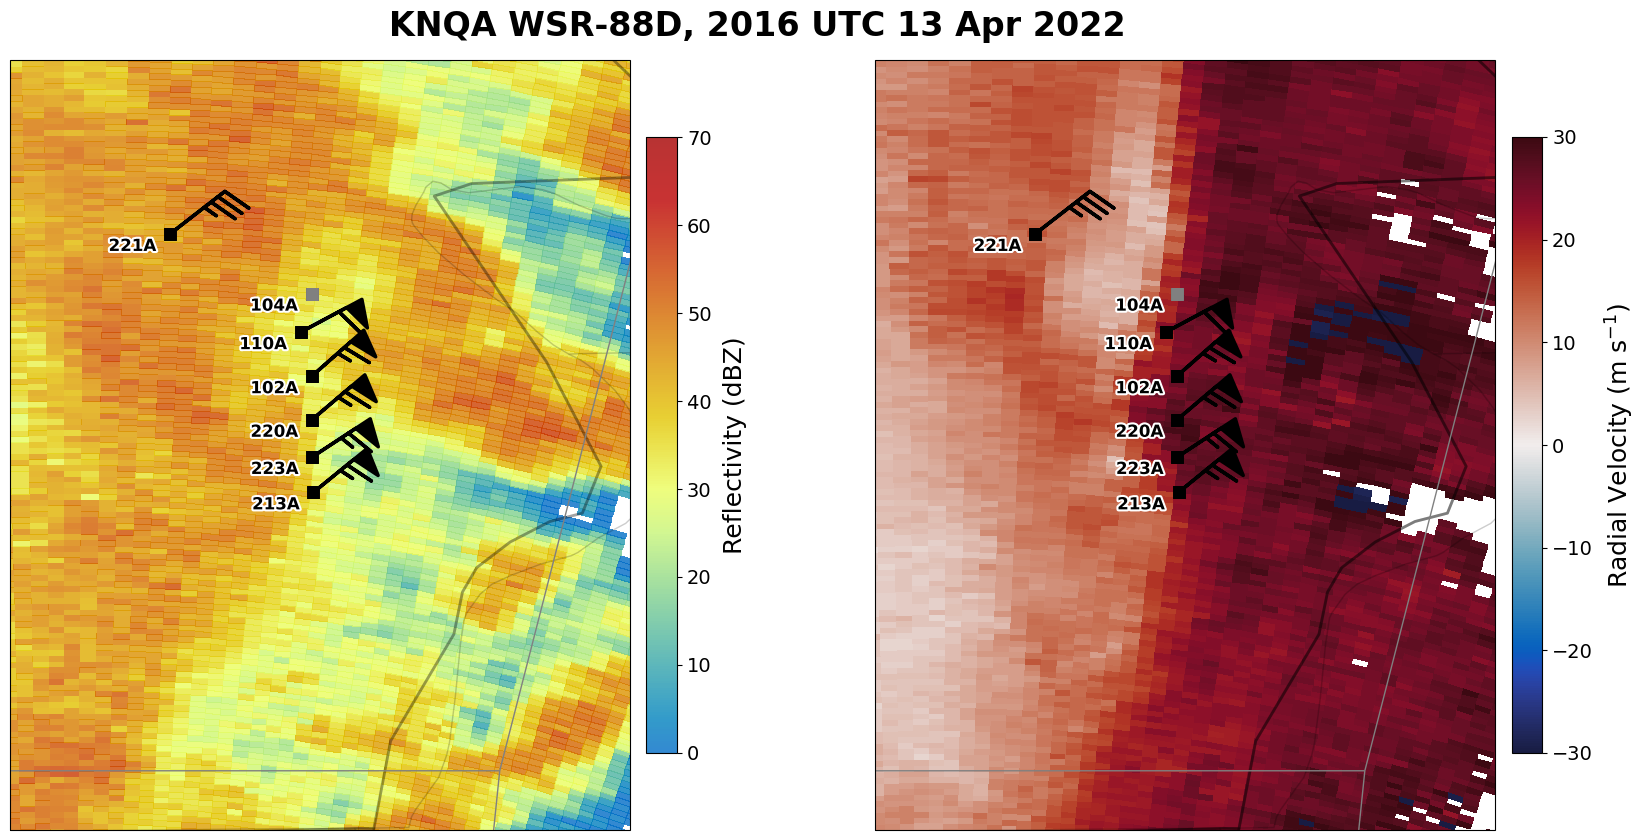

In [580]:
#station = 'KOHX'
station = 'KNQA'
from netCDF4 import num2date # KEEP THIS, num2date gets clobbered by reading in tor tracks
import matplotlib.lines as mlines

# analysis_time1 = dt.datetime(2022,4,13,20,11)
# radar_namelist1, radar_list1 = get_radar_from_aws(station, analysis_time1, analysis_time1)
# radar1 = radar_list1[0]

analysis_time2 = dt.datetime(2022,4,13,20,16)
radar_namelist2, radar_list2 = get_radar_from_aws(station, analysis_time2, analysis_time2)
radar2 = radar_list2[0]

# analysis_time3 = dt.datetime(2022,4,13,20,22)
# radar_namelist3, radar_list3 = get_radar_from_aws(station, analysis_time3, analysis_time3)
# radar3 = radar_list3[0]

plot_radar_sticknet_RefandVel(radar2, '20220413')

# mesovortex lifecycle plots

In [4]:
import matplotlib.gridspec as gridspec

def get_vals(field):
# Set plotting ranges for radar fields
    if field == 'reflectivity':
        vmin = 0
        vmax = 70
        sweep = 0
        cbar_label = 'Reflectivity (dBZ)'
        cmap = 'pyart_NWSRef'
    elif field == 'velocity':
        vmin = -30
        vmax = 30
        sweep = 1
        cbar_label = 'Radial Velocity (m/s)'
        cmap = cmocean.cm.balance#ctables.registry.get_with_steps('Carbone42', 16,16)
    return vmin,vmax,sweep,cbar_label,cmap


def plot_vel_zoom(ax1, radar, mapscale=False, legend=False):
    west_lon=-87.2
    south_lat=34
    east_lon=-86.5
    north_lat=34.6

     #lon_add, lat_add
    LL = (west_lon),(north_lat)
    UR = (east_lon ),(south_lat)
    LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
    UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())

        #ax1.set_aspect('auto')
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]

    ax1.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax1.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax1.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots

    # plot the warning poly
    poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
    plot_warnings(poly, ax1, linewidth = 3,alpha=0.8, color='#bc1010', label=None)#    

    # add the StickNets
    for n,probe in enumerate(probe_locs):
        if probe == '0107A':
            lon,lat = probe_locs[probe][1], probe_locs[probe][0]
            ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
                markersize = 8, markeredgewidth=9)
            ax1.plot(lon,lat, marker = 's', color = '#b85151', linewidth=0.0, 
                markersize = 8, markeredgewidth=5, label='SCLM')

    vmin,vmax,sweep,cbar_label,cmap = get_vals('velocity')
    vmin = -30
    vmax = 30
    cmap = cmocean.cm.balance
    #     x,y = display._get_x_y(sweep = 1, edges = False, filter_transitions = True)
    #     lon_pos,lat_pos = convert_lon_lat(ref_lon,ref_lat,x,y)

    image2 = display.plot_ppi_map('velocity', sweep, cmap=cmap, ax=ax1, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,lon_lines=[-80],
                                projection=crs)

        # plot tornado track
    tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
    ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
            color = 'k', linewidth=9)
    ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
        color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))


    
    if mapscale:
        scale_bar(ax1, length=12, location=(0.87, 0.04), linewidth=7, fontsize=16, text_pad=12)
    if legend:
        ax1.legend(loc=2, fontsize=16, framealpha=0.99)
        
        
    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
#     central = pytz.timezone('US/Central')
#     local_time = central.fromutc(time_at_start_of_radar)
#     fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
#     fancy_date_string_utc = time_at_start_of_radar.strftime('%Y-%m-%d %H:%M UTC')
    ax1.set_title(time_at_start_of_radar.strftime('%H%M UTC'), fontsize=22, y=1.01)
    
    
    

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


229 229
230 230
231 231


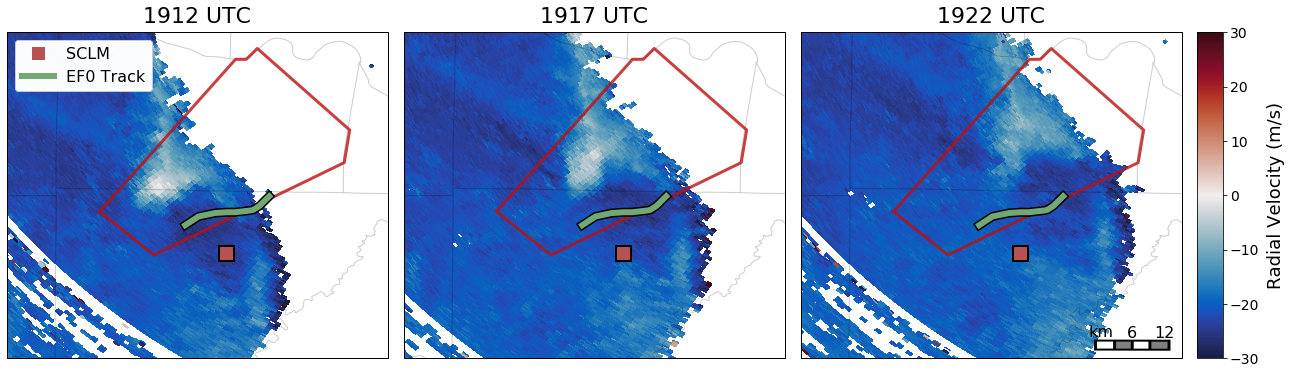

In [9]:
fig = plt.figure(figsize=(18,6))

gs = gridspec.GridSpec(1,3)
gs.update(left=0.05, right=0.96, wspace=0.03, hspace=0.15)
ax1 = plt.subplot(gs[0,0], projection=crs)
ax2 = plt.subplot(gs[0,1], projection=crs)
ax3 = plt.subplot(gs[0,2], projection=crs)

analysis_time = dt.datetime(2017,4,30,19,12)
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar1 = radar_list[0]
plot_vel_zoom(ax1, radar1, legend=True)
#del radar

analysis_time = dt.datetime(2017,4,30,19,17)
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar2 = radar_list[0]
plot_vel_zoom(ax2, radar2)
#del radar

analysis_time = dt.datetime(2017,4,30,19,22)
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar3 = radar_list[0]
plot_vel_zoom(ax3, radar3, mapscale=True)
#del radar


gs0= gridspec.GridSpec(1,1)
gs0.update(left=0.97, right=0.99, wspace=0.05)
ax_cbar=plt.subplot(gs0[0])

cmap = cmocean.cm.balance
norm = plt.Normalize(vmin=-30, vmax=30)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), pad=0.02, cax=ax_cbar)
cbar.set_label('Radial Velocity (m/s)', fontsize = 18, labelpad = 8)
cbar.ax.tick_params(labelsize = 14)

# print statement
#print('saved image from {0}'.format(fancy_date_string_utc))

 # save fig
file_dir = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/PubPlots/'
plt.savefig('{0}30AprilMV.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300);

In [5]:
#'2330','2300','2230','2200'
for time in ['1912', '1917', '1922']:
        hour = int(time[0:2]); mins=int(time[2:])
        analysis_time = dt.datetime(2017,4,30,hour, mins)
        station = 'KHTX'
        radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
        radar = radar_list[0]
#         lat_pos, lon_pos, _ = radar.get_gate_lat_lon_alt(1)
#         data_vel = radar.get_field(1,'velocity')

        date = analysis_time.strftime('%Y%m%d')
        HHMM = analysis_time.strftime('%H%M')
        fname = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/RadarSegs/{0}{1}_RadarObj.p'.format(date,HHMM)
        pickle.dump(radar, open(fname, 'wb') )

229 229
230 230
231 231


In [5]:
import scipy.ndimage as nd

def ppi_vort(radar, swp_id=1):
    ''' updated Sept 28 2020, missing the multiplication by 2'''
    vel = radar.get_field(swp_id,'velocity')#in m/s
    phi = np.unique(radar.get_elevation(swp_id))[0]#in degrees
    theta = radar.get_azimuth(swp_id)#in degrees
   
    rangearray = np.tile(radar.range['data'],(len(theta),1))# in m
    vort = np.zeros_like(vel)
    vort=2*(1./(rangearray*np.sin(np.deg2rad(90-phi))))*np.gradient(vel,np.deg2rad(theta),axis=0)
    return vort


def plot_vel_vort_zoom(ax1, radar, mapscale=False, legend=False):
    west_lon=-87.2
    south_lat=34
    east_lon=-86.5
    north_lat=34.6

     #lon_add, lat_add
    LL = (west_lon),(north_lat)
    UR = (east_lon ),(south_lat)
    LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
    UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())

        #ax1.set_aspect('auto')
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]

    ax1.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax1.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax1.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1) 

    # plot the warning poly
    poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
    plot_warnings(poly, ax1, linewidth = 2, color='#bc1010', label=None)#    

    # add the StickNets
    for n,probe in enumerate(probe_locs):
        if probe == '0107A':
            lon,lat = probe_locs[probe][1], probe_locs[probe][0]
            ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
                markersize = 8, markeredgewidth=9)
            ax1.plot(lon,lat, marker = 's', color = '#b85151', linewidth=0.0, 
                markersize = 8, markeredgewidth=5, label='SCLM')

    vmin,vmax,sweep,cbar_label,cmap = get_vals('velocity')
    vmin = -30
    vmax = 30
    cmap = cmocean.cm.balance
    image2 = display.plot_ppi_map('velocity', sweep, cmap=cmap, ax=ax1, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,lon_lines=[-80],
                                projection=crs)

        # plot tornado track
    tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
    ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
            color = 'k', linewidth=9)
    ax1.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
        color = '#71a873', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))


    
    if mapscale:
        scale_bar(ax1, length=20, location=(0.82, 0.04), linewidth=7, fontsize=16, text_pad=12)
    if legend:
        ax1.legend(loc=2, fontsize=16, framealpha=0.99)
        
        
    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])

    ax1.set_title(time_at_start_of_radar.strftime('%H%M UTC'), fontsize=22, y=1.01)
    
    
def plot_smooth_vort(ax1, radar, sigma=1.2):
    vort = ppi_vort(radar)
    vort_smooth = nd.gaussian_filter(vort, sigma = sigma)
    lat, lon, _ = radar.get_gate_lat_lon_alt(sweep=1)
    ax1.contour(lon, lat, vort_smooth, levels=np.arange(0.002, 0.0120, 0.004), colors='w', alpha=0.8)
    ax1.contour(lon, lat, vort_smooth, levels=np.arange(-0.0120,-0.002,  0.004), colors='k')   
    

/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/jessmcd/miniconda3/envs/py3_cart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


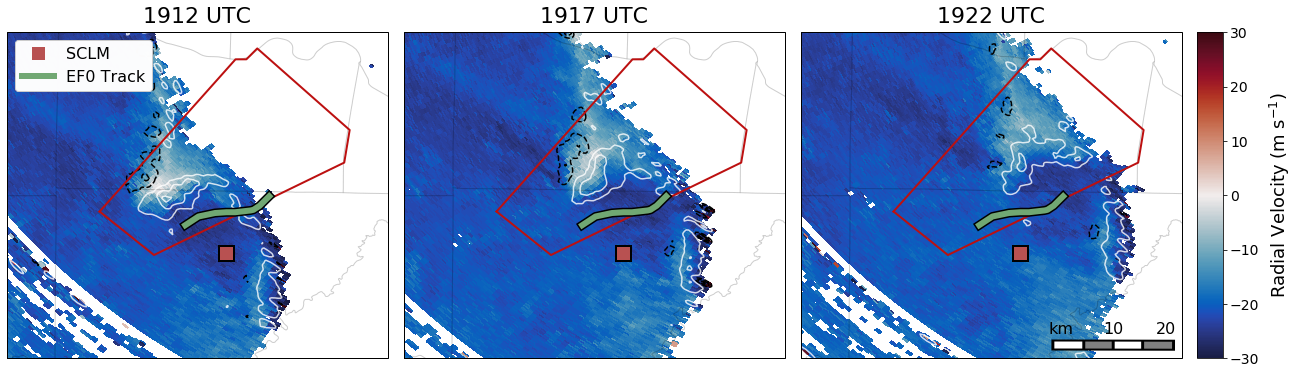

In [7]:
fig = plt.figure(figsize=(18,6))

gs = gridspec.GridSpec(1,3)
gs.update(left=0.05, right=0.96, wspace=0.03, hspace=0.15)
ax1 = plt.subplot(gs[0,0], projection=crs)
ax2 = plt.subplot(gs[0,1], projection=crs)
ax3 = plt.subplot(gs[0,2], projection=crs)


fname = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/RadarSegs/201704301912_RadarObj.p'
radar1 = pickle.load(open(fname, 'rb'))
plot_vel_vort_zoom(ax1, radar1, legend=True)
plot_smooth_vort(ax1, radar1)


fname = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/RadarSegs/201704301917_RadarObj.p'
radar2 = pickle.load(open(fname, 'rb'))
plot_vel_vort_zoom(ax2, radar2)
plot_smooth_vort(ax2, radar2)


fname = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/RadarSegs/201704301922_RadarObj.p'
radar3 = pickle.load(open(fname, 'rb'))
plot_vel_vort_zoom(ax3, radar3, mapscale=True)
plot_smooth_vort(ax3, radar3)


gs0= gridspec.GridSpec(1,1)
gs0.update(left=0.97, right=0.99, wspace=0.05)
ax_cbar=plt.subplot(gs0[0])

cmap = cmocean.cm.balance
norm = plt.Normalize(vmin=-30, vmax=30)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), pad=0.02, cax=ax_cbar)
cbar.set_label(r'Radial Velocity (m s$^{-1}$)', fontsize = 18, labelpad = 8)
cbar.ax.tick_params(labelsize = 14)

file_dir = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/NewAnalyses/PubPlots/'
plt.savefig('{0}30AprilMV.png'.format(file_dir), bbox_inches = 'tight', format='png', dpi=300);

In [82]:
radar.get_elevation(sweep=1)

array([0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.43945312, 0.43945312, 0.43945312, 0.43945312, 0.43945312,
       0.4724121 , 0.4751587 , 0.49438477, 0.49987793, 0.48339844,
       0.48339844, 0.48339844, 0.48339844, 0.48339844, 0.48339

# March 21 2017 zoom on MV

In [115]:
probe_locs

{'0102A': [34.2959, -87.5871, 282, 'SHYL', 'Haleyville'],
 '0103A': [34.8551, -86.0017, 513, 'SCMT', 'Crow Mnt'],
 '0104A': [35.3391, -87.0324, 239, 'SLYN', 'Lynnville'],
 '0105A': [34.6224, -86.08, 182, 'SSBR', 'Scottsboro'],
 '0106A': [34.2149, -87.1619, 245, 'SADN', 'Addison'],
 '0107A': [34.19439, -86.79825, 231, 'SCLM', 'Cullman'],
 '0108A': [35.3236, -86.6347, 230, 'SPBG', 'Petersburg'],
 '0109A': [35.3045, -87.5185, 315, 'SLBG', 'Lawrenceburg'],
 '0110A': [34.1632, -86.3341, 280, 'SDGS', 'Douglas'],
 '0111A': [34.5504, -86.5582, 174, 'SLYS', 'Laceys Springs'],
 '0112A': [34.7254, -87.4625, 174, 'SLGN', 'Leighton'],
 '0213A': [34.9016, -86.5386, 239, 'SHLG', 'Hazel Green'],
 '0214A': [34.9309, -86.9764, 256, 'SEMT', 'Elkmont'],
 '0215A': [35.038, -87.4719, 237, 'SSJH', 'Saint Joseph'],
 '0216A': [35.3719, -86.0998, 305, 'STLM', 'Tullahoma'],
 '0217A': [34.6176, -87.1014, 192, 'SDTR', 'Decatur']}

In [134]:
def plot_mar21(radar, date, warning_poly = None, event=None):
    """ Function takes in a radar object and data from StickNets to plot the surface observations
    on top of the radar sweep. 
    Required inputs:
        radar: pyart radar object
        data: dictionary of sticknet T,P,RH,etc.
        obstime: Valid time of StickNet data
    Optional inputs:
        field: radar field name given in a string (i.e., reflectivity, velocity)
    """
    #Set up Plot
    crs = ccrs.PlateCarree()
    # Get data to plot state and province boundaries
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lakes',
            scale='10m',
            facecolor='none')
    west_lon=-87.5
    south_lat=35
    east_lon=-86.7
    north_lat=35.56
      # add the rapid probes                

    #lon_add, lat_add
    LL = (west_lon),(north_lat)
    UR = (east_lon ),(south_lat)
    LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
    UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())
    

    
    # Initialize plot and basemap
    fig = plt.figure(figsize = [22,8])
    
    
    
    
    # REFLECTIVITY
    ax =  fig.add_subplot(121, projection=crs)
    #ax.set_aspect('auto')
        
    ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots


    # add the StickNets
     # add the StickNets
    for n,probe in enumerate(probe_locs):
        if probe == '0104A':
            lon,lat = probe_locs[probe][1], probe_locs[probe][0]
            ax.plot(lon,lat, marker = 's', color = 'w', linewidth=0.0, 
                markersize = 8, markeredgewidth=7)
            ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
                markersize = 8, markeredgewidth=5, label='SLYN')
 
    vmin,vmax,sweep,cbar_label,cmap = get_vals('reflectivity')
    cmap = pyart.graph.cm_colorblind.HomeyerRainbow
    
        # Grab indeces and times from radar object
    
    field = 'reflectivity'
    sweep = 2
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    # getting contours

    ref_lat = display.loc[0]
    ref_lon = display.loc[1]
 
    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    central = pytz.timezone('US/Central')
    local_time = central.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    fancy_date_string_utc = time_at_start_of_radar.strftime('%Y-%m-%d %H:%M UTC')

    
    image = display.plot_ppi_map('reflectivity', sweep, cmap=cmap, ax=ax, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs)
  
    # adds larger title and gives stylistic control over colorbar
  
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax)
    cbar.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar.ax.tick_params(labelsize = 14)
     #title
    title = '{0} {1} \n{2} ({3})'.format(station,'WSR-88D',fancy_date_string,fancy_date_string_utc)
    plt.suptitle(title, fontsize = 22)
    
    # add legend and mapscale
    handles, labels =ax.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),fontsize=14, loc=2, framealpha=1)
    
       
    # Mark the radar
    ax.plot(lon_0, lat_0, marker='o', color='r', label='KHTX')



    
    #VELOCITY
    
    ax1 = fig.add_subplot(122, projection=crs)
    #ax1.set_aspect('auto')
    display = pyart.graph.RadarMapDisplay(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]
    
    ax1.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax1.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax1.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.1) # 20m, 5m 500k sizes from large to small
    # use 20m for testing, and 500k for final plots


    # add the StickNets
    for n,probe in enumerate(probe_locs):
        if probe == '0104A':
            lon,lat = probe_locs[probe][1], probe_locs[probe][0]
            ax1.plot(lon,lat, marker = 's', color = 'w', linewidth=0.0, 
                markersize = 8, markeredgewidth=7)
            ax1.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
                markersize = 8, markeredgewidth=5, label='SLYN')

            
    vmin,vmax,sweep,cbar_label,cmap = get_vals('velocity')
    vmin = -30
    vmax = 30
    cmap = cmocean.cm.balance

        
    image2 = display.plot_ppi_map('velocity', sweep, cmap=cmap, ax=ax1, vmin=vmin, vmax=vmax,
                                 colorbar_label=cbar_label, title_flag=False, colorbar_flag=False,
                                projection=crs)


 
    # adds larger title and gives stylistic control over colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),pad=0.02, ax=ax1,)
    cbar2.set_label(cbar_label, fontsize = 18, labelpad = 8)
    cbar2.ax.tick_params(labelsize = 14)
    
    # Mark the radar
    ax1.plot(lon_0, lat_0, marker='o', color='r', label='KHTX')
    

    scale_bar(ax1, length=20, location=(0.87, 0.03), linewidth=8, fontsize=14, text_pad=10)
    
    plt.subplots_adjust(wspace=0.03)#, top = .89) #.03,.84

    # print statement
    print('saved image from {0}'.format(fancy_date_string_utc))

180 180
saved image from 2017-03-21 21:17 UTC


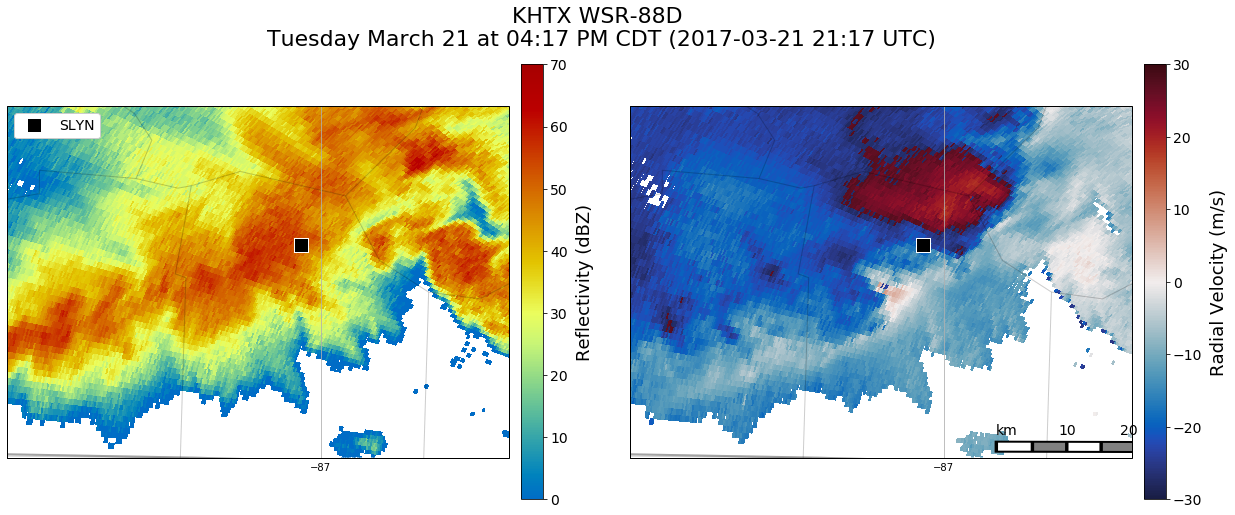

In [135]:
analysis_time = dt.datetime(2017,3,21,21,15)
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar = radar_list[0]
plot_mar21(radar, date, warning_poly = None, event=None)

# general trash

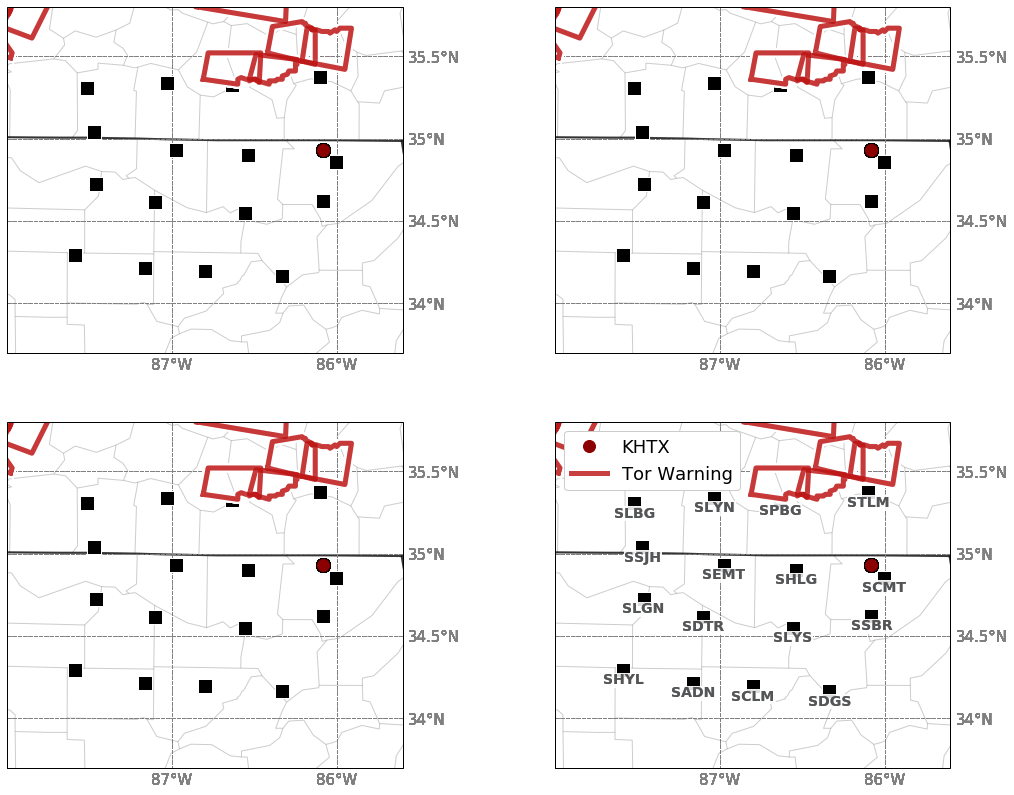

In [620]:
#fig = plt.figure(1, figsize=(18, 14))
fig, axes = plt.subplots(2,2, figsize=(18, 14), subplot_kw={'projection': crs})

for row in axes:
    for ax in row:
        ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
        ax.add_feature(states_provinces, edgecolor='k', alpha=0.5, linewidth=2)
        ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.1) # 20m, 5m 500k sizes from large to small
                                                            # use 20m for testing, and 500k for final plots
    # add the StickNets
        for n,probe in enumerate(probe_locs):
            if n <16:
                lat,lon = probe_locs[probe][0],probe_locs[probe][1]
                ax.plot(lon,lat, marker = 's', color = 'w', linewidth=0.0, 
                        markersize = 10, markeredgewidth=5)
                ax.plot(lon,lat, marker = 's', color = 'k', linewidth=0.0, 
                        markersize = 10, markeredgewidth=3)
                plt.text(lon,lat-.06, probe_locs[probe][3], fontsize=14,\
                             ha='center', va='center', weight='bold', color='#545556',\
                             bbox=dict(facecolor='w', alpha=0.4, edgecolor='w', pad=0))


                # Mark the radar
                lat_0,lon_0 = 34.93055725097656,-86.08361053466797 # KHTX
                ax.plot(lon_0, lat_0, marker='o', color='k', linewidth=0.0,markersize = 14, label='KHTX')
                ax.plot(lon_0, lat_0, marker='o', color='darkred', linewidth=0.0,markersize = 12, label='KHTX')

                # plot the warning poly
                poly = pickle.load(open('{0}_TorPoly.p'.format(date), 'rb'))
                # plot_warning_cartopy(poly, ax, linewidth = 6,alpha=0.8, color='w',label = 'Tor Warning')#
                # plot_warning_cartopy(poly, ax, linewidth = 3,alpha=0.8, color='#bc1010',label = 'Tor Warning')#
                plot_warning_cartopy(poly, ax, linewidth = 9,alpha=0.8, color='w',label = 'Tor Warning')#
                plot_warning_cartopy(poly, ax, linewidth = 5,alpha=0.8, color='#bc1010',label = 'Tor Warning')#

                # add lat lons
                lons, lats =[-88, -87, -86, -85],[33.5, 34.0,34.5, 35.0, 35.5, 36]
                plot_lat_lon(ax, lons, lats)

# Plot Radar Outlines

# i = 0

# for hour in [6,5]:
#     for mins in [30, 0]:
#         analysis_time = dt.datetime(2017,3,10,hour, mins)
#         date = analysis_time.strftime('%Y%m%d')
#         HHMM = analysis_time.strftime('%H%M')
#         #fname = '/media/jessmcd/MyPassport/VortexSE/RadarSegs/{0}{1}_ReflecData.p'.format(date,HHMM)
#         fname = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/RadarSegs/{0}{1}_ReflecData.p'.format(date,HHMM)

#         rdata = pickle.load(open(fname, 'rb'))
#         lons, lats, ref = rdata[0], rdata[1], rdata[2]
#         print(np.shape(ref))
        
#         smoothed = nd.gaussian_filter(ref, sigma = 1.8)
#         smooth = ref#nd.gaussian_filter(ref, sigma = 1.1)
  
#         newcmap=make_cmap([rgb('#ffffff'),rgb(clist[i])])
    
#         ax.contourf(lons, lats, smooth, levels=[30,55], colors='w', alpha=.7)
#         ax.contourf(lons, lats, smooth, levels=np.arange(30,70,5), cmap=min_col(newcmap, minval=.3), alpha=1)
#         i+=1

        
        


# plot tornado track
# tortrack = pickle.load(open('20170430_TorTrack.p', 'rb'))
# ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = 'k', linewidth=9)
# ax.plot(tortrack.iloc[0]['lons'],tortrack.iloc[0]['lats'], 
#         color = '#46855a', linewidth=6, label='{} Track'.format(tortrack.loc[0]['rating']))

# legend
handles, labels =ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),fontsize=18, loc=2, framealpha=1)

# add scale bar
# scale_bar(ax, length=50, location=(0.84, 0.05), linewidth=14, fontsize=14)


(720, 1832)
(720, 1832)
(720, 1832)
(720, 1832)
(720, 1832)
(720, 1832)


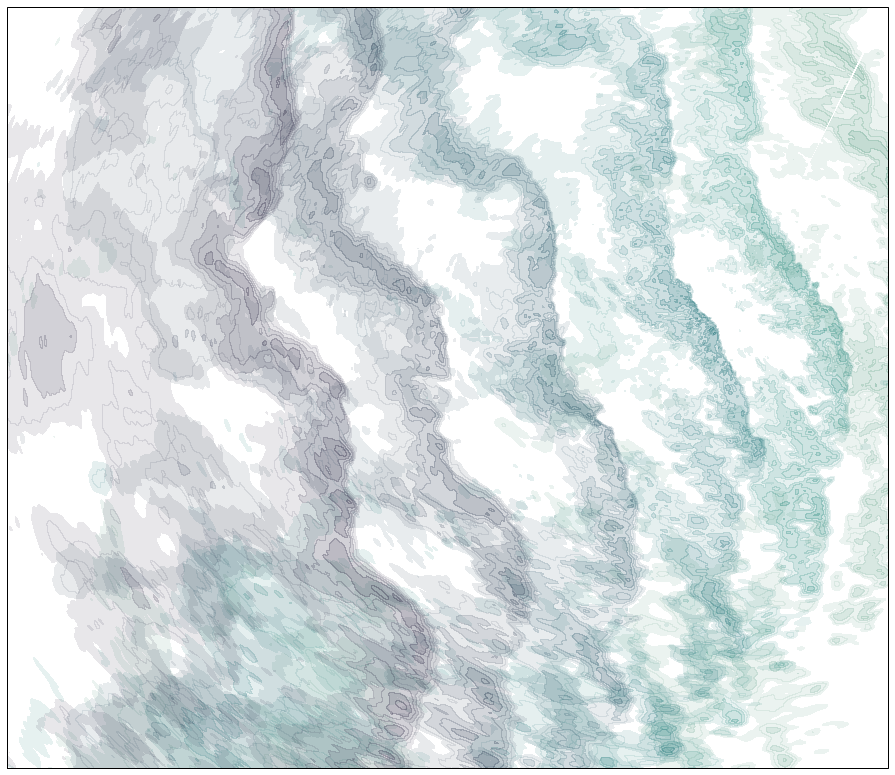

In [46]:
import pickle
fig = plt.figure(1, figsize=(18, 14))
ax = plt.subplot(111, projection=crs)
west_lon=-87.9
south_lat=33.8
east_lon=-85.7
north_lat=35.7


#lon_add, lat_add
LL = (west_lon),(north_lat)
UR = (east_lon ),(south_lat)
LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())
ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)

       
        
# Plot Radar Outlines
i = 0
ilist = np.linspace(0.5, 0.9, 6)
ilist = [cmocean.cm.rain(0.5),cmocean.cm.rain(0.6),cmocean.cm.rain(0.7),
        cmocean.cm.rain(0.8),cmocean.cm.rain(0.9),cmocean.cm.rain(.99)]
#clist = ['#337a55','#115696','#111e96','#4f1196','#861196']
for hour in [21,20,19]:
    for mins in [30,0]:
        analysis_time = dt.datetime(2017,4,30,hour, mins)
        date = analysis_time.strftime('%Y%m%d')
        HHMM = analysis_time.strftime('%H%M')
        fname = '/Users/jessmcd/Documents/MyPassport_backup/VortexSE/RadarSegs/{0}{1}_ReflecData.p'.format(date,HHMM)

        rdata = pickle.load(open(fname, 'rb'))
        lons, lats, ref = rdata[0], rdata[1], rdata[2]
        print(np.shape(ref))
   
        smooth = nd.gaussian_filter(ref, sigma = 1.1)
        
        #newcmap=make_cmap([rgb('#ffffff'),cmocean.cm.rain(ilist[i])])
        ax.contourf(lons, lats, smooth, levels=np.arange(30,45,5), colors=[ilist[i]], alpha=0.1)
        ax.contourf(lons, lats, smooth, levels=np.arange(40,55,5), colors=[ilist[i]], alpha=0.2)
        ax.contourf(lons, lats, smooth, levels=np.arange(50,75,5), colors=[ilist[i]], alpha=0.3)
        i+=1


    #i+=1
    
plt.show()

In [14]:
import cmocean

In [19]:
cmocean.cm.deep(0.1)

(0.792043685530358, 0.9216117772405966, 0.6969810377273069, 1.0)

In [136]:
keys = ['a', 'a', 'b', 'b', 'c','c']
vals = [(1,2), (2,3), (1,2), (2,3), (1,2), (2,3)]

In [143]:
dict=dict.fromkeys(np.unique(keys))
for k,v in zip(keys,vals):
    dict[k] = dict[k], v

In [144]:
dict

{'a': ((None, (1, 2)), (2, 3)),
 'b': ((None, (1, 2)), (2, 3)),
 'c': ((None, (1, 2)), (2, 3))}

In [156]:
dict= {'a':vals[0:int(1*len(vals)/3)], 
       'b':vals[int(1*len(vals)/3) : int(2*len(vals)/3)],
       'c':vals[int(2*len(vals)/3):]}

In [157]:
dict

{'a': [(1, 2), (2, 3)], 'b': [(1, 2), (2, 3)], 'c': [(1, 2), (2, 3)]}

In [151]:
len(vals)/3

2.0